# Figure 2:  Stable clonal behaviors

Main questions: are the stable behaviors identified in the previous dataset (P1902) short-term or long-term.  Are they stable across different activation events which trigger massive changes in cell state -- activation of a resting memory T cell to become effectors?

* Panel (a):  Mr. Pokey
* Panel (b):  Confusion matrix, all clones.
* Panel (c):  Confusion matrix, sister clones.
* Panel (d):  Heatmap, sister clones.
* Panel (e):  Clone and well significance.
* Panel (f):  Violins.

# Loading packages and data

We begin by importing various packages and functions. This notebook requires Python 3.5 or later, together with numpy, pandas, matplotlib, seaborn, statsmodels, scipy, scikit-learn (sklearn), bisect, and itertools.

## Loading and prepping the packages.

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
import statsmodels.api as sm

from IPython.display import display # Pretty display of data frames.

# Import various functions for stats.
from scipy.stats import f_oneway, binom, binom_test, kruskal, norm # For p-values, kruskal-wallis, Gaussian
from scipy.stats import kurtosis, skew, zscore # For detecting bimodality
import scipy.cluster.hierarchy as sch # For hierarchical clustering.
import scipy.stats as ss

from statsmodels.formula.api import ols

# Matplotlib stuff
from matplotlib.patches import Rectangle,Circle


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.
# from sklearn import mixture  # Import Gaussian mixture

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

import anndata

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


To create small-image panels for larger figures, we do a bit of extra work.  First, we set some font sizes to 5-7pt, to match the guidelines in *Nature*.

In [2]:
import matplotlib.font_manager as fm

font = fm.FontProperties(
        family = 'Helvetica', fname = '/System/Library/Fonts/Helvetica.ttc')

In [3]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

Matplotlib is kind of ridiculous when it comes to actually setting the size of images correctly.  The following solution is from https://kavigupta.org/2019/05/18/Setting-the-size-of-figures-in-matplotlib/.  At least it's close to correct!

In [6]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

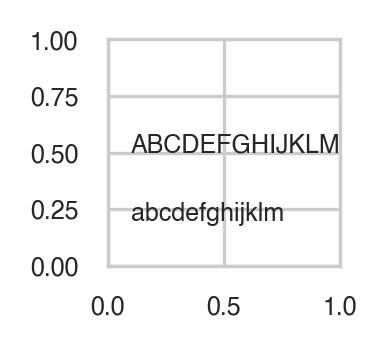

In [7]:

sns.set_style('whitegrid')
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
#set_size(fig, (1,1))
#plt.savefig("Panels/TestFont.pdf", bbox_inches='tight')
plt.show()

## Loading the data

Here we load the data:  anndata objects with gene expression, and metadata about genes and single cells.

In [8]:
experiment = 'P3128'
file_prefix = '../Data/Processed/'
file_suffix = '.loom'  
datasets = ['sc', 'bulks']
adata = {}
for ds in datasets:
    adata[ds] = anndata.read_loom(file_prefix+experiment+'_'+ds+file_suffix)
    adata[ds].var_names = adata[ds].var['gene_name']
    adata[ds].obs_names = adata[ds].obs['obs_names']

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
for ds in datasets:
    print('Data for {} loaded'.format(ds))
    print(adata[ds])
    print('------------------------------------')

Data for sc loaded
AnnData object with n_obs × n_vars = 324 × 8693
    obs: 'Cell_Number', 'Clone_ID', 'Condition', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'Well_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'total_counts_mt'
    var: 'F_pval', 'GC_content', 'K_pval', 'chi2_pval', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells_by_counts', 'on_ratio', 'pathway', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'
------------------------------------
Data for bulks loaded
AnnData object with n_obs × n_vars = 38 × 11043
    obs: 'Cell_Number', 'Clone_ID', 'Condition', 'Day', 'In_Vivo_Clone_ID', 'Project_ID', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'total_counts', 'to

We also load the protein data, from pickles.

In [10]:
protein_df = pd.read_pickle(file_prefix+experiment+'_protein.pkl') # Load proteins from a pickle.

In this experiment, there are 20 clones (identified by T-cell receptor), and these are placed into 24 wells.  16 clones are placed in 16 separate wells.  The other 4 clones are distributed into 8 wells.  So each of these four clones is split roughly in half, in two wells each.  But there was a (lucky?) mistake, and one well received two clones.  Oops.

In [11]:
genes = list(adata['sc'].var_names)  # The names of the genes. 
cells = list(adata['sc'].obs_names) # The names of the cells.
bulks = list(adata['bulks'].obs_names) # The names of the bulks.

proteins = list(protein_df.columns) # The names of the proteins
paired_proteins = [p for p in proteins if p in genes] # Proteins with paired genes.

In [12]:
clones = adata['sc'].obs.Clone_ID.unique()
wells = adata['sc'].obs.Well_ID.unique()
print('There are {} clones found:  {}'.format(len(clones), ', '.join(clones)))
print('There are {} wells found:  {}'.format(len(wells), ', '.join(wells)))

There are 20 clones found:  3, 11, 55, 41, 7, 8, 9, 13, 18, 44, 14, 54, 6, 48, 32, 47, 27, 1, 29, 12
There are 24 wells found:  D2, H3, D6, F7, A2, B6, C6, E7, B12, C2, H6, F11, B4, E8, D1, A7, D10, F6, A8, G3, F4, E2, B10, H4


It will be useful later to look at both clone and well simultaneously, so we track that below.

In [13]:
adata['sc'].obs['CloneWell'] = adata['sc'].obs.Clone_ID.astype(str) + '_' + adata['sc'].obs.Well_ID.astype(str)
adata['sc'].obs.CloneWell.unique()

array(['3_D2', '11_H3', '55_D6', '41_F7', '7_A2', '8_B6', '9_C6', '13_E7',
       '13_B12', '18_C2', '44_H6', '14_F11', '54_B4', '6_E8', '48_D1',
       '32_A7', '47_D10', '27_F6', '1_A8', '29_G3', '12_F4', '1_E2',
       '54_B10', '11_H4', '54_H4'], dtype=object)

We log-normalize the protein data.

In [14]:
prolog = protein_df.copy()  # Make a copy in memory
prolog = prolog.apply(lambda column: column - column.min()) # Shift minima to zero.
prolog = prolog.transform(np.log1p) # Apply log(1+x) transform.

We summarize the data that has been loaded.

In [15]:
print("The expression matrix captures {} cells and {} gene expressions.".format(len(cells), len(genes)))
print("The protein matrix captures {} cells and {} proteins.".format(len(prolog), len(proteins)))
print("There are {} proteins paired with genes: {}.".format(len(paired_proteins), ', '.join(paired_proteins)))
print("Our cell metadata contains {} cells in {} clones and {} wells.".format(len(cells), len(clones), len(wells)))

The expression matrix captures 324 cells and 8693 gene expressions.
The protein matrix captures 324 cells and 7 proteins.
There are 5 proteins paired with genes: FAS, CD3E, CD8A, PDCD1, CD27.
Our cell metadata contains 324 cells in 20 clones and 24 wells.


We examine our expression matrix.

In [16]:
adata['sc'].to_df()

gene_name,WASH7P,MTND2P28,hsa-mir-6723,MTATP6P1,LINC01128,NOC2L,ISG15,RP11-465B22.3,C1orf159,TNFRSF18,...,PRKY,AC010970.2,RNA5-8SP6,TTTY15,USP9Y,DDX3Y,UTY,TXLNG2P,KDM5D,EIF1AY
obs_names,,,,,,,,,,,,,,,,,,,,,
P3128_1193,1.185056,3.949547,3.416790,6.756408,0.000000,5.188991,0.000000,0.000000,0.000000,6.941271,...,0.000000,6.727557,2.538142,3.256414,0.0,0.000000,0.000000,0.000000,0.000000,5.077693
P3128_1194,0.920368,2.412111,2.318799,6.510733,0.000000,0.515025,0.000000,6.022605,0.000000,6.970009,...,0.000000,6.911946,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.625366
P3128_1195,0.000000,3.682434,2.105202,6.258027,4.194329,0.000000,5.539803,5.373451,0.199121,7.940547,...,0.000000,7.641040,0.000000,2.505105,0.0,4.195312,0.000000,4.596088,4.100421,5.001608
P3128_1197,0.000000,2.946494,2.433361,6.285403,0.000000,5.544540,5.151440,0.663145,0.000000,6.487695,...,0.000000,6.883107,5.026728,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
P3128_1198,0.816068,4.106129,2.295633,6.442999,5.273019,0.000000,5.026237,5.618218,0.000000,6.536946,...,0.000000,7.576640,4.249540,0.000000,0.0,4.282655,0.000000,0.000000,0.000000,3.879998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P3128_1569,2.293427,3.381210,3.054985,6.678146,0.000000,4.654272,0.000000,0.000000,0.000000,0.000000,...,2.396737,8.344687,0.000000,0.000000,0.0,0.000000,0.000000,4.944156,0.000000,2.716323
P3128_1570,1.857111,3.919406,2.077507,5.798772,0.000000,0.000000,5.677753,0.000000,0.000000,7.669584,...,4.456810,8.494008,5.447612,0.000000,0.0,0.000000,0.260802,3.975459,3.950647,4.157176
P3128_1571,1.647888,3.586856,2.873020,6.352665,0.000000,0.000000,5.394394,0.000000,0.000000,5.336452,...,0.743120,7.636262,0.000000,3.475323,0.0,4.933496,2.304696,0.000000,3.303219,0.000000


For analysis, we put the expression matrix into a feature matrix X, and clones, wells, and clonewells into separate series.

In [17]:
X = adata['sc'].to_df().copy()  # The features.  Copied in memory, just in case.
y_clone = adata['sc'].obs.Clone_ID # We are trying to predict clonality from the features.
y_well = adata['sc'].obs.Well_ID
y_clonewell = adata['sc'].obs.CloneWell

yshuff_clone = pd.Series(np.random.permutation(y_clone.values), index=y_clone.index, name='Clone_ID')
yshuff_well = pd.Series(np.random.permutation(y_well.values), index=y_well.index, name='Well_ID')

In [30]:
all_genes_P3128 = adata['sc'].var['F_pval']
all_genes_P3128.to_csv('../Data/all_genes_P3128.csv')

In [33]:
P3128_sigs = adata['sc'].var.F_pval.sort_values()[:500]
P3128_sigs.to_csv('../Data/clonal_genes_P3128.csv')
P3128_sigs

gene_name
KLRC1            1.422734e-45
KLRB1            7.502311e-45
REG4             4.729890e-43
HPGD             2.461113e-38
CD9              7.669740e-31
                     ...     
RPL22L1          1.119250e-03
MANF             1.131071e-03
WDR59            1.163288e-03
SERF2            1.180095e-03
RP11-501C14.9    1.183207e-03
Name: F_pval, Length: 500, dtype: float64

In [20]:
def ANOVA_p(X,y):
    args = [X[y == k] for k in np.unique(y)]
    pvals = f_oneway(*args)[1] # Use f_oneway for high precision.
    return pd.Series(pvals, index=X.columns, name='pval') # Built-in ANOVA F from scikit.

In [28]:
P3128_shuff_sigs = ANOVA_p(X,yshuff_clone).sort_values()[:500]
P3128_shuff_sigs.to_csv('../Data/clonal_decoy_genes_P3128.csv')

In [29]:
len(P3128_shuff_sigs)

500

# Gene protein correlation

Here we analyze the correlation between gene expression and protein expression, for those few instances where we have both bits of information.

In [20]:
paired_proteins # These are the proteins where we have both gene and protein expression.

['FAS', 'CD3E', 'CD8A', 'PDCD1', 'CD27']

We load the background levels, and rename the proteins to match the other data.

In [21]:
pro_back = pd.read_csv('../Data/Raw/200922_FMO values.csv')
pro_back.columns = [col.split(' ')[0] for col in pro_back.columns]
pro_back.columns = pro_back.columns.map({'CD3':'CD3E', 'CD8':'CD8A', 'PD1':'PDCD1', 'CD27':'CD27', 'CD95':'FAS'})
pro_back.head()

,CD3E,CD8A,PDCD1,CD27,FAS
0,-13.2026,-9.53947,125.5750,8.80708,-99.3837
1,-69.3289,-43.01540,90.4819,38.31570,39.5909
2,-54.1868,280.79800,118.7470,53.06270,4.4515
3,-22.8834,289.15100,45.9653,66.63910,-76.8243
4,-47.9918,169.29800,10.1674,-93.97790,-70.7983


## Supplemental figure -- gene protein correlation plots.

In [40]:
pro_back

,CD3E,CD8A,PDCD1,CD27,FAS
0,-13.2026,-9.53947,125.5750,8.80708,-99.3837
1,-69.3289,-43.01540,90.4819,38.31570,39.5909
2,-54.1868,280.79800,118.7470,53.06270,4.4515
3,-22.8834,289.15100,45.9653,66.63910,-76.8243
4,-47.9918,169.29800,10.1674,-93.97790,-70.7983
...,...,...,...,...,...
5080,NaN,NaN,NaN,NaN,-138.5520
5081,NaN,NaN,NaN,NaN,-61.7988
5082,NaN,NaN,NaN,NaN,-99.2002
5083,NaN,NaN,NaN,NaN,-74.5836


In [105]:
y_clone.loc[progene_cells].nunique()

20

In [107]:
y_clone

obs_names
P3128_1193     3
P3128_1194     3
P3128_1195     3
P3128_1197     3
P3128_1198     3
              ..
P3128_1569    54
P3128_1570    11
P3128_1571    11
P3128_1572    11
P3128_1574    54
Name: Clone_ID, Length: 324, dtype: object

In [118]:
y_well

obs_names
P3128_1193    D2
P3128_1194    D2
P3128_1195    D2
P3128_1197    D2
P3128_1198    D2
              ..
P3128_1569    H4
P3128_1570    H4
P3128_1571    H4
P3128_1572    H4
P3128_1574    H4
Name: Well_ID, Length: 324, dtype: object

In [112]:
[clone for clone in y_clone.unique() if clone not in y_clone.loc[protein_df[pp].loc[progene_cells].dropna().index].unique()]

['29']

In [148]:
progene_cells = cells

mm = 1 / 25.4

def geneprot_plot(pp, glom = 'Well'):
    figsize=(175*mm, 50*mm)
    fig,ax = plt.subplots(1,3,figsize=figsize, sharey=True, dpi=300)
    setfontsize()
    
    fig.subplots_adjust(wspace=0.05)
    
    RNA = X[pp].loc[progene_cells].copy()
    PRO = protein_df[pp].loc[progene_cells].copy()
    PROBK = pro_back[pp].copy()
    minshift = PROBK.min() - 2
    PROBK = np.log(PROBK - minshift) / np.log(2)
    PRO = np.log(PRO - minshift) / np.log(2)
    PRO = PRO.dropna()
    RNA = RNA.loc[PRO.index]
    
    ### PROTEIN ONLY by clone
    
    plot_df = pd.DataFrame(index=RNA.index)
    plot_df[pp+' Protein'] = PRO
    plot_df['Clone'] = y_clone.astype(str)
    
    clones_ordered = ['3', '6', '7', '8', '9', '12' , '14', '18', '27', '29', '32',
                      '41',  '44', '47','48', '55','1', '13', '11', '54']
    
    pal = sns.color_palette(n_colors=len(clones_ordered))
    pal = pal[-1::-1]
    lut = dict(zip(clones_ordered, pal))
    
    plot_df['Clone'] = plot_df['Clone'].astype(pd.CategoricalDtype(categories=clones_ordered, ordered=True))
    plot_df = plot_df.sort_values(by='Clone')
    
    if glom == 'Clone':
        plot_df['x_no'] = y_clone.astype(str)
        plot_df['x'] = 'Clone'+plot_df['x_no']
    elif glom == 'Well':
        plot_df['x_no'] = y_well.astype(str)
        plot_df['x'] = 'Well'+plot_df['x_no']
        plot_df = plot_df[plot_df['x_no'] != 'H4'] # Drop bad well!
        
    PROBK_low = PROBK.quantile(0.1) - 1
    sns.rugplot(y=PROBK[PROBK >= PROBK_low], ax=ax[0], height=0.04, clip_on=False, alpha=0.25, 
                color='yellow', linewidth=1.0, expand_margins=False)
    sns.rugplot(y=PROBK[PROBK >= PROBK_low], ax=ax[0], height=0.04, clip_on=False, alpha=0.05, 
                color='blue', linewidth=1.0, expand_margins=False)
    ax[0].text(-0.5, PROBK.max()+0.5, 'Background', color='darkblue', rotation=90, 
               ha='center', va='bottom', clip_on=False, bbox={'facecolor':'white', 
                                                              'alpha':0.5,
                                                              'pad':0,
                                                             'edgecolor':'white'})
    
    sns.scatterplot(x = 'x_no', y = pp+' Protein', hue='Clone', palette=lut, s=10, data=plot_df, ax=ax[0])
    print(plot_df['x'].nunique())
    #xtl = [lab.get_text() for lab in ax[0].get_xticklabels()]
    #print(plot_df['CloneNo'].unique())
    ax[0].tick_params(axis='x', rotation=90, pad=-1)
    ax[0].set_ylim(np.min([PRO.quantile(0.1) - 1, PROBK.quantile(0.1) - 1]), np.max([PRO.max() + 1, PROBK.max() + 1]))
    ax[0].set_ylabel(pp+' Protein')
    ax[0].set_xlabel(glom)
    
    
    ### RNA and PROTEIN cell by cell
    
    R2_cell = (np.corrcoef(RNA.values, PRO.values)**2)[0,1]
    plot_df[pp+' RNA'] = RNA
    sns.scatterplot(x=pp+' RNA',y=pp+' Protein', hue='Clone', palette=lut, data=plot_df, s=10, ax=ax[1])
    sns.regplot(x=pp+' RNA',y=pp+' Protein', data=plot_df, ax=ax[1], scatter=False, color='k',
               line_kws = {'linewidth':1.0})
    PROBK = PROBK[PROBK >= PRO.quantile(0.1) - 1] # Easy clip
    
    ### Averages###
    
    ave_df = plot_df.groupby('x').mean()
    ave_df['Clone'] = ''
    if glom == 'Well':
        for well in ave_df.index:
            clone = plot_df[plot_df['x'] == well]['Clone'][0]
            ave_df.loc[well,'Clone'] = clone
    #display(ave_df)    
    R2_aves = (np.corrcoef(ave_df[pp+' RNA'], ave_df[pp+' Protein'])**2)[0,1]
    
    xrange = (max(plot_df[pp+' RNA'].quantile(0.05) - 1,-1), plot_df[pp+' RNA'].max()+1.0)
    yrange = (max(plot_df[pp+' Protein'].quantile(0.05) - 1,-1), plot_df[pp+' Protein'].max()+1.0)
    PROBK = PROBK[PROBK >= yrange[0]] # Easy clip
    
    #sns.rugplot(y=PROBK, ax=ax[2], height=0.04, clip_on=False, alpha=0.25, 
    #            color='yellow', linewidth=1.0, expand_margins=False)
    #sns.rugplot(y=PROBK, ax=ax[2], height=0.04, clip_on=False, alpha=0.05, 
    #            color='blue', linewidth=1.0, expand_margins=False)
    
    
    sns.scatterplot(x=pp+' RNA',y=pp+' Protein', hue='Clone', palette=lut, data=plot_df, ax=ax[2], 
                    alpha=0.5, s=10)
    sns.scatterplot(x=pp+' RNA',y=pp+' Protein', hue='Clone', palette=lut, data=ave_df, ax=ax[2],
                   marker='D', edgecolor='k', s=20)
    sns.regplot(x=pp+' RNA',y=pp+' Protein', data=ave_df, ax=ax[2], scatter=False, color='k',
               line_kws = {'linewidth':1.0})
    
    ax[0].legend().remove()
    ax[1].legend().remove()
    ax[2].legend().remove()
    
    ax[2].set_xlim(xrange)
    #ax[2].set_ylim(yrange)
    #yl = ax[1].get_ylim()
    #xl = ax[1].get_xlim()
    #ax[0].add_patch(plt.Rectangle((xl[0],yl[0]), xl[1] - xl[0], yl[1]-yl[0], zorder=5, color=(0.4,0.2,0), 
    #                                fill=False, linestyle='--', linewidth=2, alpha=0.9))
    #ax[1].add_patch(plt.Rectangle((xl[0],yl[0]), xl[1] - xl[0], yl[1]-yl[0], zorder=5, color=(0.4,0.2,0), 
    #                                fill=False, linestyle='--', linewidth=4, alpha=0.9))
    ax[0].set_title('Protein expression by {}'.format(glom.lower()))
    ax[1].set_title('Single cell: protein~gene $R^2$ = {:1.3f}'.format(R2_cell))
    if glom == 'Clone':
        ax[2].set_title('Clonal averages: protein~gene $R^2$ = {:1.3f}'.format(R2_aves))
    elif glom == 'Well':
        ax[2].set_title('Well averages: protein~gene $R^2$ = {:1.3f}'.format(R2_aves))
    
    set_size(fig, figsize)
    plt.savefig("Panels/GeneProtein/{}_geneprot.pdf".format(pp), bbox_inches='tight')
    plt.show()

22


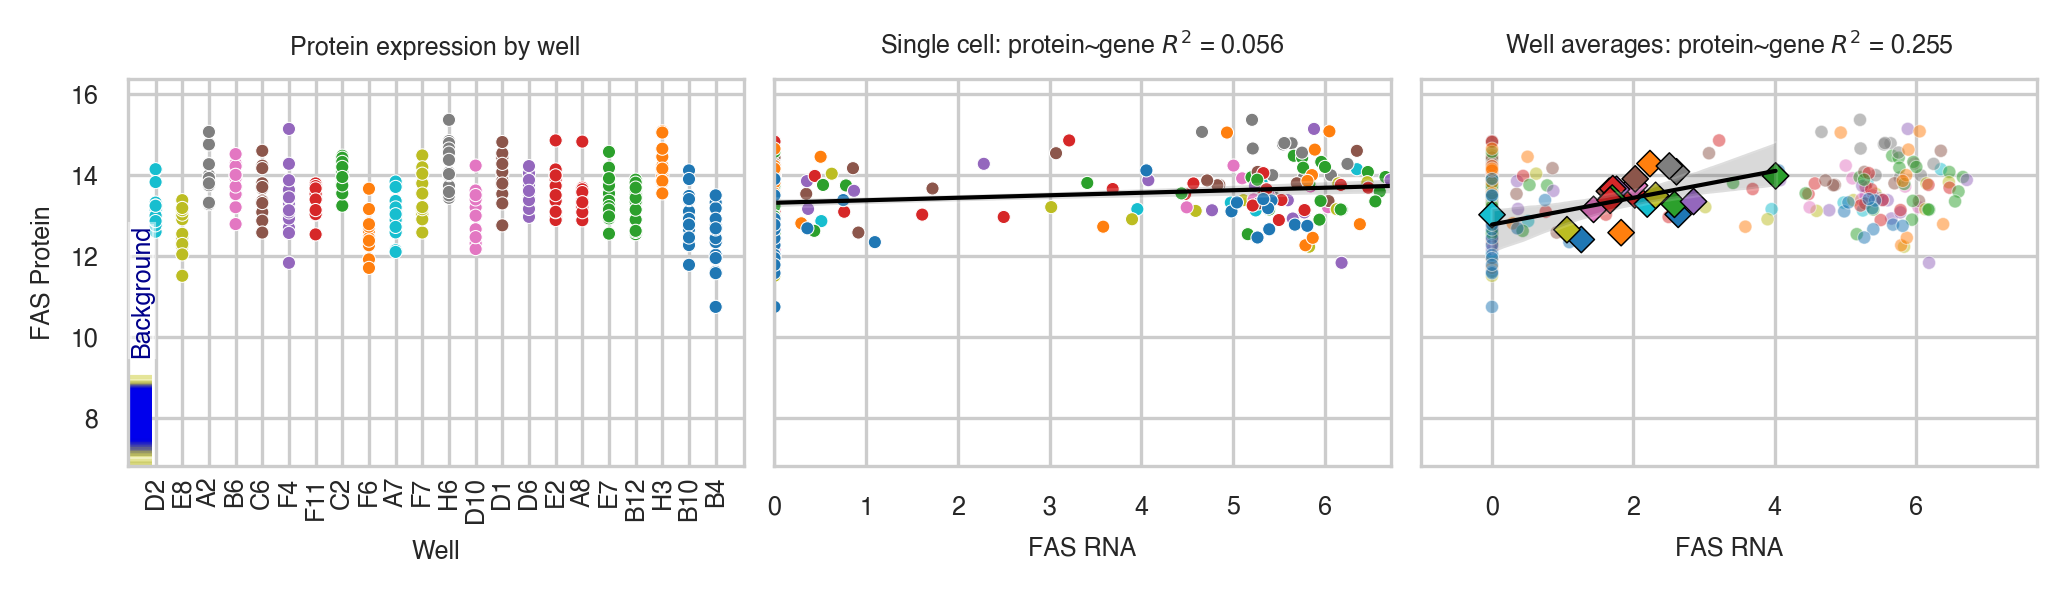

In [149]:
geneprot_plot('FAS')

22


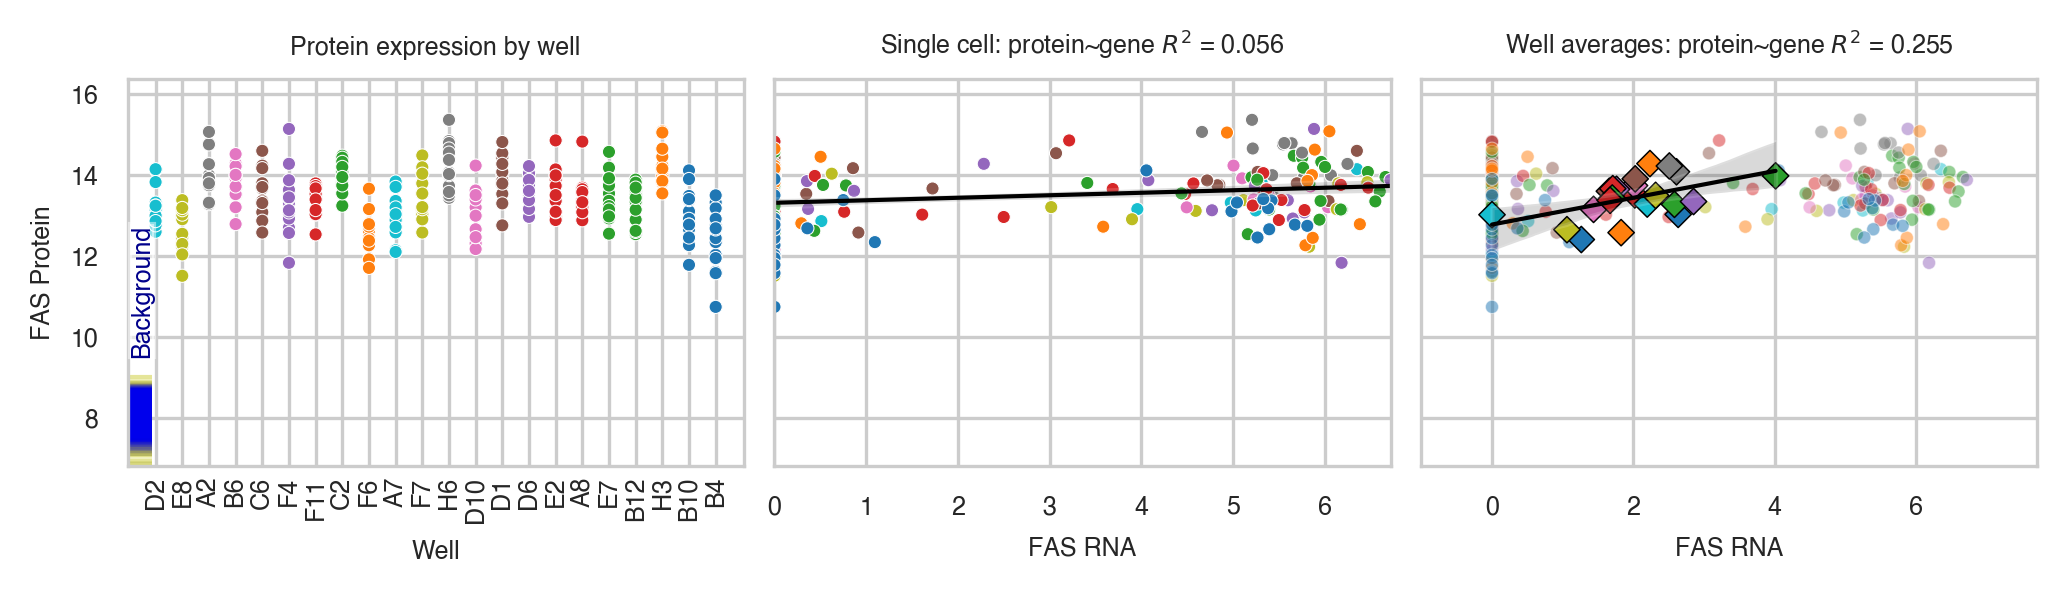

22


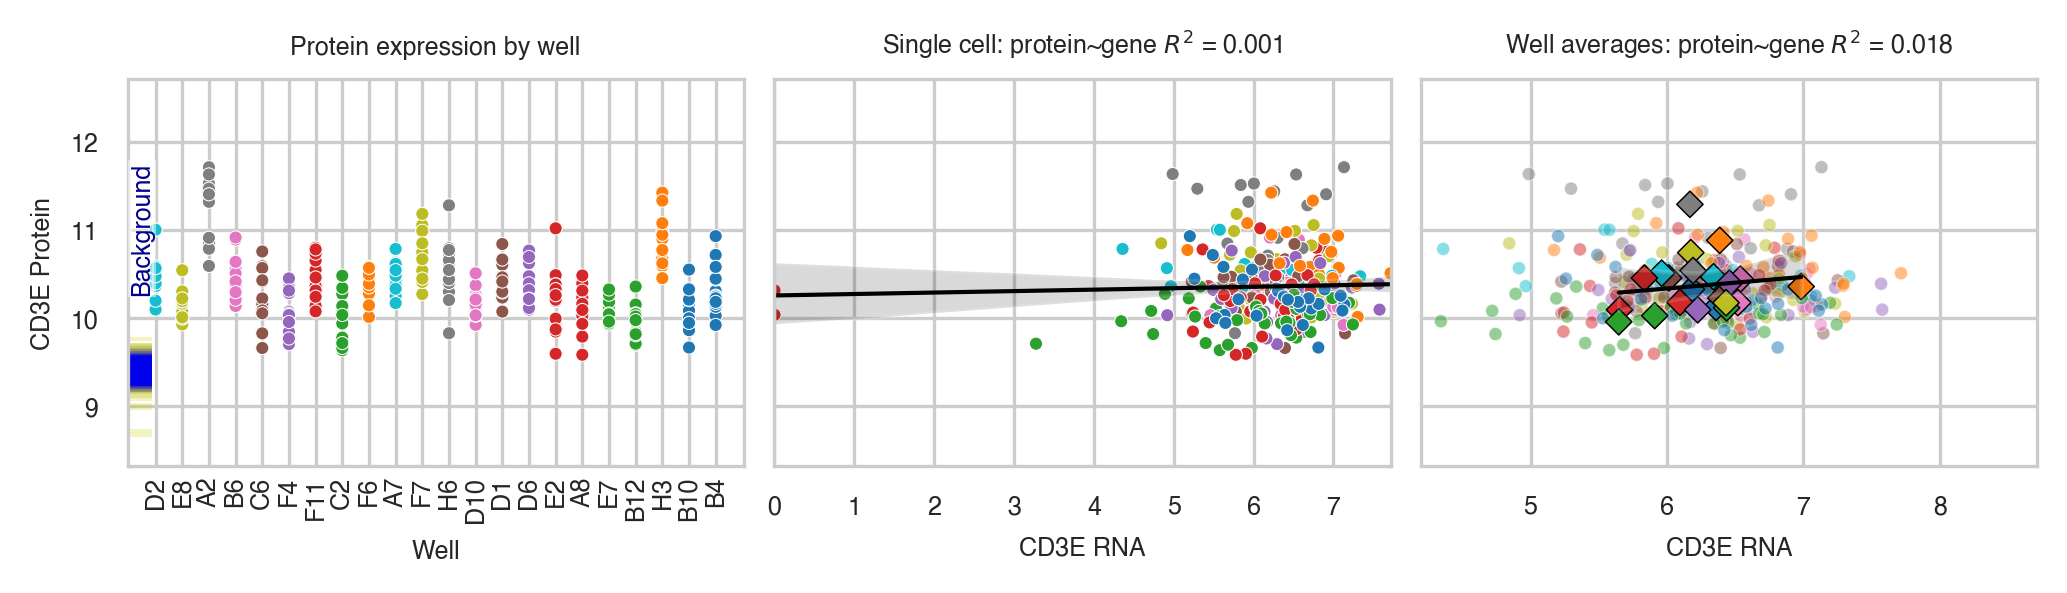

22


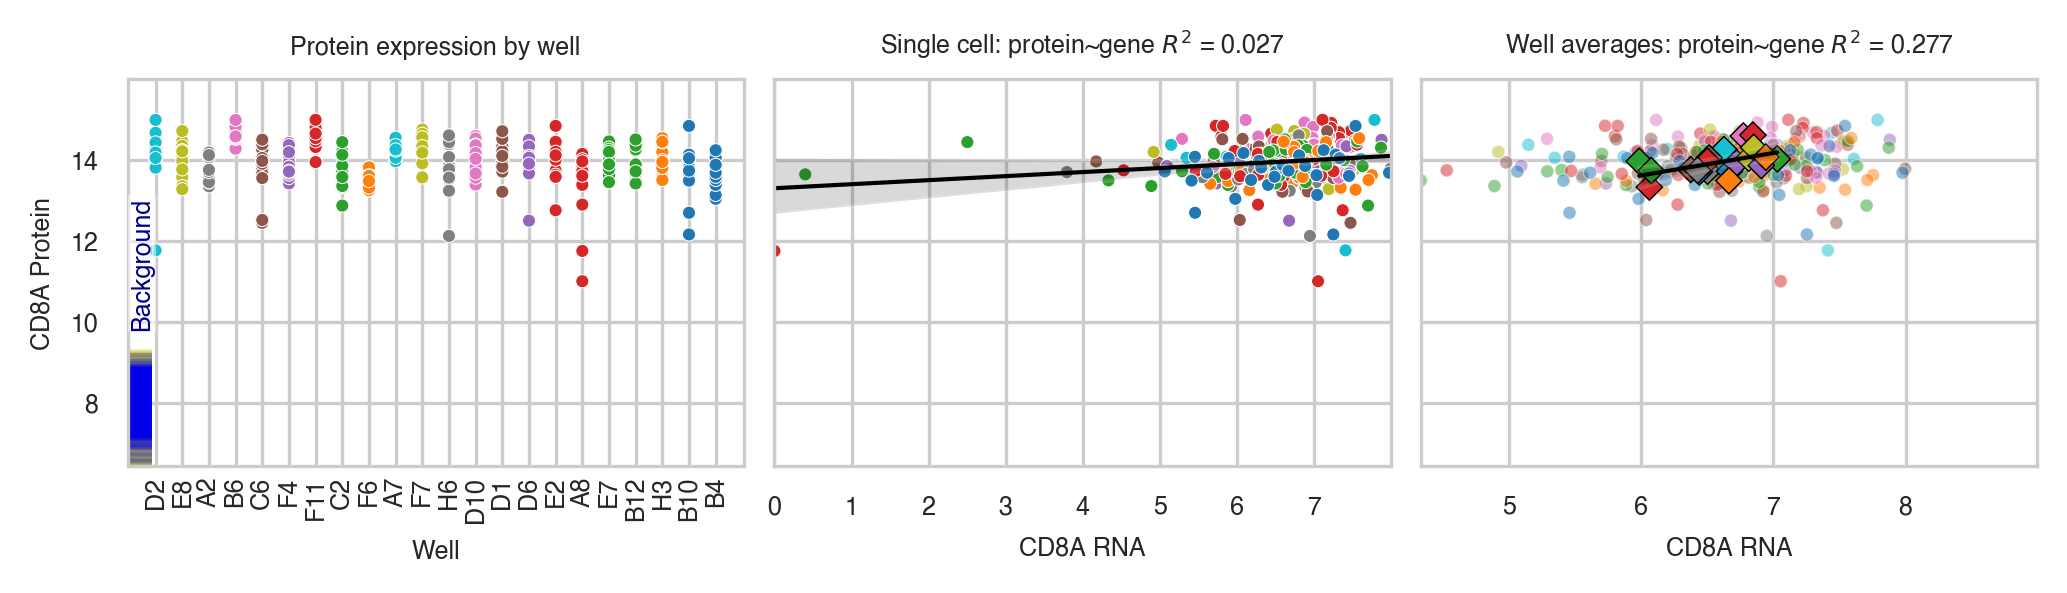

22


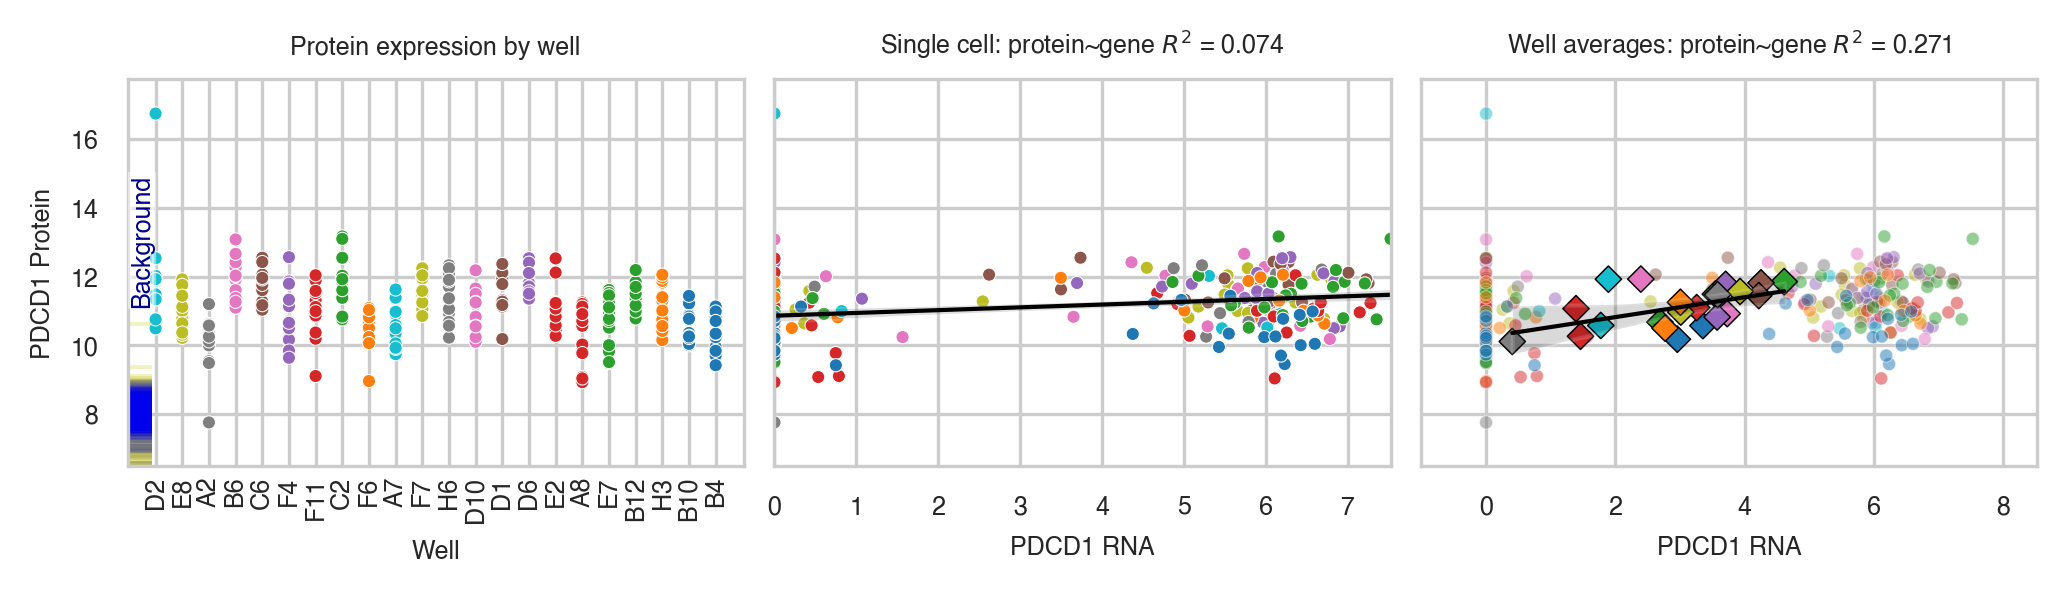

22


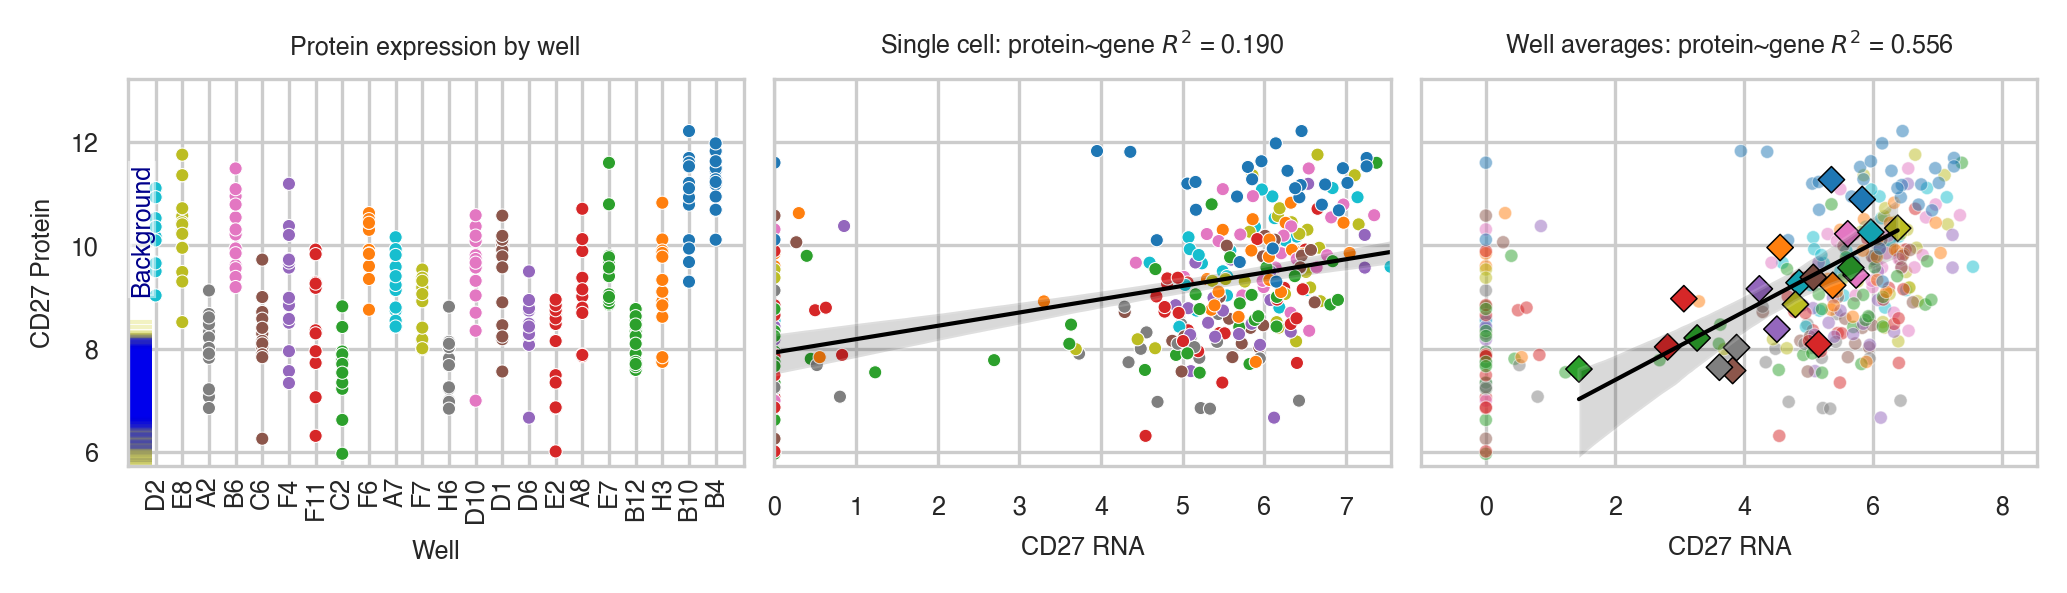

In [150]:
for pp in paired_proteins:
    geneprot_plot(pp)

Here is an alternative visualization... without background plots.

In [ ]:
no_pp = len(paired_proteins)
fig,ax= plt.subplots(5,2, figsize=(10, 26))
progene_cells = [cell for cell in prolog.index if cell in X.index]

desetfontsize()

for j,prot in enumerate(paired_proteins):
    RNA = X[prot].loc[progene_cells]
    PRO = prolog[prot].loc[progene_cells]
    plot_df = pd.DataFrame(index=RNA.index)
    plot_df[prot+' RNA'] = RNA
    plot_df[prot+' Protein'] = PRO
    plot_df['Clone'] = 'Clone'+y_clone.astype(str)
    sns.scatterplot(x=prot+' RNA',y=prot+' Protein', hue='Clone', data=plot_df, ax=ax[j, 0])
    sns.regplot(x=prot+' RNA',y=prot+' Protein', data=plot_df, ax=ax[j, 0], scatter=False)
    
    ave_df = plot_df.groupby('Clone').mean()
    sns.scatterplot(x=prot+' RNA',y=prot+' Protein', hue=ave_df.index, data=ave_df, ax=ax[j, 1],
                   marker='D', s=100)
    sns.regplot(x=prot+' RNA',y=prot+' Protein', data=ave_df, ax=ax[j, 1], scatter=False, color='orange')
    ax[j,0].legend().remove()
    ax[j,1].legend().remove()
    ax[j,0].set_ylim(plot_df[prot+' Protein'].quantile(0.02) - 1, plot_df[prot+' Protein'].quantile(0.9)+1)
    yl = ax[j,1].get_ylim()
    xl = ax[j,1].get_xlim()
    ax[j,0].add_patch(plt.Rectangle((xl[0],yl[0]), xl[1] - xl[0], yl[1]-yl[0], zorder=5, color=(0.4,0.2,0), 
                                    fill=False, linestyle='--', linewidth=2, alpha=0.9))
    ax[j,1].add_patch(plt.Rectangle((xl[0],yl[0]), xl[1] - xl[0], yl[1]-yl[0], zorder=5, color=(0.4,0.2,0), 
                                    fill=False, linestyle='--', linewidth=2, alpha=0.9))
    ax[j,0].set_title('Single cell gene/protein')
    ax[j,1].set_title('Clonal averages gene/protein')

# Supplement:  Copy number variation, X/Y chromosome genes

# THIS PART IS A MESS

First, we load a list of genes on the X and Y chromosomes.  This is slightly adapted from a list sent by Jeff.  Adaptations were to make gene names line up with the ENSG data elsewhere.    

In [151]:
gene_metadata = pd.read_csv('../Data/Raw/P9855_All_Gene_Info_Metadata.csv', sep=',',
                       index_col=0, header=0, low_memory=False)
print('{} genes loaded.'.format(len(gene_metadata)))
gene_metadata.head()

196248 genes loaded.


,hgnc_symbol,chromosome_name,start_position,end_position,transcription_start_site,gene_biotype
ensembl_gene_id,,,,,,
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66119285,protein_coding
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66320895,protein_coding
ENSG00000261657,SLC25A26,HG991_PATCH,66119285,66465398,66339287,protein_coding
ENSG00000223116,NaN,13,23551994,23552136,23552136,miRNA
ENSG00000233440,HMGA1P6,13,23708313,23708703,23708313,pseudogene


In [152]:
genes_X = gene_metadata[gene_metadata.chromosome_name == 'X'].hgnc_symbol.unique()
genes_X = [gene for gene in genes_X if gene in X.columns]
print('{} genes found on X chromosome: {}'.format(len(genes_X), ', '.join(genes_X)))

163 genes found on X chromosome: PIN4, RPS4X, NKRF, GTPBP6, GRIPAP1, SLC25A6, ASMTL, P2RY8, AKAP17A, RPL39, DHRSX, ZBED1, CD99, PRAF2, UPF3B, PRKX, RNF113A, NDUFA1, TBL1X, NKAP, LINC00892, WWC3, HCCS, RLIM, ABCB7, MSL3, PRPS2, TMSB4X, EGFL6, RAB9A, OFD1, UPRT, RPS23P8, GEMIN8, LAMP2, MOSPD2, CUL4B, JPX, FTX, CA5B, ZRSR2, MCTS1, AP1S2, C1GALT1C1, SYAP1, TXLNG, RBBP7, PHKA2, THOC2, PDHA1, XIAP, SH3KBP1, P2RY10, GPR174, ITM2A, CXorf23, STAG2, EIF1AX, RPS6KA3, MBTPS2, SMS, PRDX4, ACOT9, SAT1, APOO, EIF2S3, ZFX, PDK3, POLA1, SH2D1A, CXorf21, GK, DMD, SH3BGRL, DYNLT3, RPGR, SASH3, BCOR, ATP6AP2, CXorf38, MED14, UTP14A, USP9X, CHM, DDX3X, AIFM1, FUNDC1, KDM6A, DIAPH2, KRBOX4, RAB33A, SLC25A14, USP11, ARAF, ELK1, UXT, RBMX2, CSTF2, VAMP7, IL9R, CD99P1, ENOX2, TRMT2B, TSR2, CA5BP1, RAP2C, MAGED2, FAM3C2, MBNL3, APEX2, GAPDHP1, FAM104B, MAGEH1, RRAGB, PHF6, HPRT1, UBQLN2, SPIN2B, FAM122B, MOSPD1, ZC4H2, FAM127A, FAM127B, LAS1L, MSN, BEX4, TCEAL8, FHL1, MAP7D3, YIPF6, MORF4L2, HTATSF1, PJA1, CD40

In [153]:
genes_Y = gene_metadata[gene_metadata.chromosome_name == 'Y'].hgnc_symbol.unique()
genes_Y = [gene for gene in genes_Y if gene in X.columns]
print('{} genes found on Y chromosome: {}'.format(len(genes_Y), ', '.join(genes_Y)))

11 genes found on Y chromosome: USP9Y, DDX3Y, UTY, TXLNG2P, PRKY, KDM5D, EIF1AY, RNA5-8SP6, TTTY15, RPS4Y1, ZFY


In [155]:
genes_XY_df = pd.read_csv('../Data/Raw/ChrXandY_Genes.csv', index_col=0)
genes_XY = list(genes_XY_df.index)
genes_XY = [gene for gene in genes_XY if gene in genes]

print('We have {} XY genes in our expression matrix.'.format(len(genes_XY)))

We have 10 XY genes in our expression matrix.


In [159]:
genes_XY_df

,ENSEMBLE
Gene Symbol,
PLCXD1,NaN
GTPBP6,NaN
PPP2R3B,NaN
SHOX,NaN
CRLF2,NaN
CSF2RA,NaN
IL3RA,NaN
SLC25A6,NaN
ASMTL,NaN


In [156]:
dmXY = gene_metadata.loc[genes_XY_df.index]['chromosome_name']
dmXY = dmXY[~dmXY.index.duplicated(keep='first')]
genes_XY_df['chrome'] = dmXY
print(genes_XY_df.gene_name)

KeyError: "None of [Index(['PLCXD1', 'GTPBP6', 'PPP2R3B', 'SHOX', 'CRLF2', 'CSF2RA', 'IL3RA',\n       'SLC25A6', 'ASMTL', 'P2RY8', 'AKAP17A', 'ASMT', 'DHRSX', 'ZBED1',\n       'CD99', 'SPRY3', 'VAMP7', 'IL9R', 'WASH6P'],\n      dtype='object', name='ensembl_gene_id')] are in the [index]"

In [160]:
def classminiheat(ef, mf, genelist, classlist = None, classname = 'Well', filename=None, hpush = 0):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        filename:  If given, the filename to save the figure, e.g. 'heatmap.pdf'
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    md = pd.DataFrame(index=mf.index)
    md[classname] = mf
    #md = mf
    if classlist == None: 
        classlist = md[classname].unique()
    
    display(md)
    md.sort_values(classname, inplace=True)
    df = df.loc[md.index]
    #md.sort_values(classname, key=classlist, inplace=True)
    #df.sort_values(classname, key=classlist, inplace=True)
    
    
    
    df = df.drop(df.columns[-1],axis=1)
    #df.columns = [gene_names[gene] for gene in df.columns]
    # Create plot.
    
    # Set (small) figure size and fonts
    figsize=(2.4,2.5)
    
    sns.set_style("white")
    setfontsize()
    
    
    # Create colors for clones (or whatever classes)
    pal = sns.color_palette(n_colors=len(classlist))
    pal = pal[-1::-1]
    lut = dict(zip(classlist, pal))
    colors = pd.DataFrame(index=df.index)
    colors[classname] = md[classname].map(lut)
    
    
    cg = sns.clustermap(df.transpose(), z_score=0, cmap="coolwarm", vmin=-2, vmax=2, 
                        col_colors=colors, figsize=figsize, col_cluster=False, row_cluster=False,
                        dendrogram_ratio=(0.01,0.01), colors_ratio=0.05, cbar_pos = None)
        
    
    cg.fig.set_dpi(300)
    #cg.cax.set_position([0.75+hpush, .3, .02, .4]) # Colorbar.
    
    ax = cg.ax_heatmap # Main heatmap axis.
    #ax.set_yticks([])
    ax.set_ylabel('')
    #ytl = ax.get_yticklabels()
    #print([gene for gene in ytl])
    #ax.set_yticklabels([gene_names[gene.get_text()] for gene in ytl if gene.get_text() in gene_names.index])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    # Clone labels
    j = 0
    for cl in classlist:
        no_label = len(md[md[classname] == cl])
        if np.mean(lut[cl]) < 0.5: # Dark colors get light labels.
            textcolor = (1,0.8,0.8)
        else: # Light colors get dark labels.
            textcolor = (0,0,0)   
        j += no_label / 2
        cg.ax_col_colors.text(j,0.7,cl, color=textcolor, ha='center')
        j += no_label / 2
        
    
    # Figure title
    figtitle = 'Expression (z-score) for {} genes.'.format(len(genelist))
    plt.suptitle(figtitle, ha='left', x=0.05, y=1)   
    
    if filename:
        #plt.savefig(filename, pad_inches = 0, dpi = 300)
        set_size(cg.fig, (4, 2.5))
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [161]:
welllist = ['A2', 'A7', 'A8', 'B4', 'B6', 'B10', 'B12', 'C2', 'C6', 'D1', 'D2', 'D6', 'D10', 'E2', 'E7', 'E8', 
            'G3','H3', 'H4', 'H6', 'F4', 'F6', 'F7', 'F11']

In [162]:
adata['sc'].to_df()['CD99']

obs_names
P3128_1193    6.931748
P3128_1194    7.349767
P3128_1195    6.820878
P3128_1197    7.296730
P3128_1198    7.283377
                ...   
P3128_1569    7.126109
P3128_1570    7.310369
P3128_1571    7.296560
P3128_1572    7.665690
P3128_1574    6.589740
Name: CD99, Length: 324, dtype: float32

We use some different labels for well numbers.

In [163]:
CNV_ids = pd.read_csv('../Data/Raw/P3128_Clone_ID_Well_ID.csv', index_col = 0)
CNV_ids

,Donor,Condition,HLA Type,Batch,Clone ID,Cell Number,In_Vivo_Clone_Number,Clone_Number_In-Vitro,Vb,CNV_ID_NUMBER,...,Nuc_Seq_TRB,Va,Ja,TCR Alpha,Nuc_Seq_TRA,Va2,Ja2,TCR Alpha2,Nuc_Seq_TRA_2,Notes
Sample ID,,,,,,,,,,,,,,,,,,,,,
P3128_1193,M,InVitro,A2,30,D2,1,98,3.0,TRBV29-1,1,...,TGCAGCGTCGCCACTAGCGGGGGATCCAATGAGCAGTTCTTC,TRAV12-2,TRAJ27,CAVIAGKSTF,TGTGCCGTGATTGCAGGCAAATCAACCTTT,NaN,NaN,NaN,NaN,NaN
P3128_1194,M,InVitro,A2,30,D2,1,98,3.0,TRBV29-1,1,...,TGCAGCGTCGCCACTAGCGGGGGATCCAATGAGCAGTTCTTC,TRAV12-2,TRAJ27,CAVIAGKSTF,TGTGCCGTGATTGCAGGCAAATCAACCTTT,NaN,NaN,NaN,NaN,NaN
P3128_1195,M,InVitro,A2,30,D2,1,98,3.0,TRBV29-1,1,...,TGCAGCGTCGCCACTAGCGGGGGATCCAATGAGCAGTTCTTC,TRAV12-2,TRAJ27,CAVIAGKSTF,TGTGCCGTGATTGCAGGCAAATCAACCTTT,NaN,NaN,NaN,NaN,NaN
P3128_1196,M,InVitro,A2,30,D2,1,98,3.0,TRBV29-1,1,...,TGCAGCGTCGCCACTAGCGGGGGATCCAATGAGCAGTTCTTC,TRAV12-2,TRAJ27,CAVIAGKSTF,TGTGCCGTGATTGCAGGCAAATCAACCTTT,NaN,NaN,NaN,NaN,NaN
P3128_1197,M,InVitro,A2,30,D2,1,98,3.0,TRBV29-1,1,...,TGCAGCGTCGCCACTAGCGGGGGATCCAATGAGCAGTTCTTC,TRAV12-2,TRAJ27,CAVIAGKSTF,TGTGCCGTGATTGCAGGCAAATCAACCTTT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P3128_1572,M,InVitro,A2,33,H4,1,none,11.0,TRBV20-1,24,...,TGCAGTGCTAGTGCCAGGGGTGAGACTGAAGCTTTCTTT,TRAV12-2,TRAJ31,CAVSNARLMF,TGTGCCGTCTCTAATGCCAGACTCATGTTT,NaN,NaN,NaN,NaN,NaN
P3128_1573,M,InVitro,A2,33,H4,1,none,NaN,NaN,24,...,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN
P3128_1574,M,InVitro,A2,33,H4,1,5,54.0,TRBV19,24,...,TGTGCCAGTAGGCCGGGACAGGGATACGAGCAGTACTTC,TRAV12-2,TRAJ41,CAVTGYALNF,TGTGCCGTTACCGGGTATGCACTCAACTTC,NaN,NaN,NaN,NaN,NaN


In [164]:
adata['sc'].obs['CNV_ID'] = CNV_ids.CNV_ID_NUMBER.astype(str)
adata['sc'].obs

,Cell_Number,Clone_ID,Condition,Day,In_Vivo_Clone_ID,Project_ID,Well_ID,log1p_n_genes_by_counts,log1p_total_counts,log1p_total_counts_mt,n_genes,n_genes_by_counts,obs_names,pct_counts_mt,total_counts,total_counts_mt,CloneWell,CNV_ID
obs_names,,,,,,,,,,,,,,,,,,
P3128_1193,1.0,3,In_Vitro,NaN,3.0,P3128,D2,8.190632,9.682444,5.087666,3606,3606,P3128_1193,1.004272,16032.631836,161.011322,3_D2,1
P3128_1194,1.0,3,In_Vitro,NaN,3.0,P3128,D2,7.644919,9.183422,5.043312,2089,2089,P3128_1194,1.582000,9733.404297,153.982452,3_D2,1
P3128_1195,1.0,3,In_Vitro,NaN,3.0,P3128,D2,8.248006,9.680780,5.016290,3819,3819,P3128_1195,0.936216,16005.976562,149.850571,3_D2,1
P3128_1197,1.0,3,In_Vitro,NaN,3.0,P3128,D2,8.047510,9.520891,4.913070,3125,3125,P3128_1197,0.990095,13640.760742,135.056458,3_D2,1
P3128_1198,1.0,3,In_Vitro,NaN,3.0,P3128,D2,8.229244,9.695534,5.078405,3748,3748,P3128_1198,0.982017,16243.892578,159.517776,3_D2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P3128_1569,1.0,54,In_Vitro,NaN,54.0,P3128,H4,8.426393,9.841041,5.163271,4565,4565,P3128_1569,0.924700,18788.265625,173.735092,54_H4,24
P3128_1570,1.0,11,In_Vitro,NaN,11.0,P3128,H4,8.325791,9.770586,5.167016,4128,4128,P3128_1570,0.995948,17510.019531,174.390732,11_H4,24
P3128_1571,1.0,11,In_Vitro,NaN,11.0,P3128,H4,8.187021,9.672627,5.089599,3593,3593,P3128_1571,1.016154,15876.010742,161.324783,11_H4,24


In [194]:
adata['sc'].to_df().groupby(adata['sc'].obs['CNV_ID'])[genes_Y_pl].mean().melt(ignore_index=False)

,gene_name,value
CNV_ID,,
1,USP9Y,0.000000
2,USP9Y,0.255850
3,USP9Y,0.459617
4,USP9Y,0.479896
5,USP9Y,0.167196
...,...,...
20,ZFY,0.807997
21,ZFY,0.305402
22,ZFY,0.000000


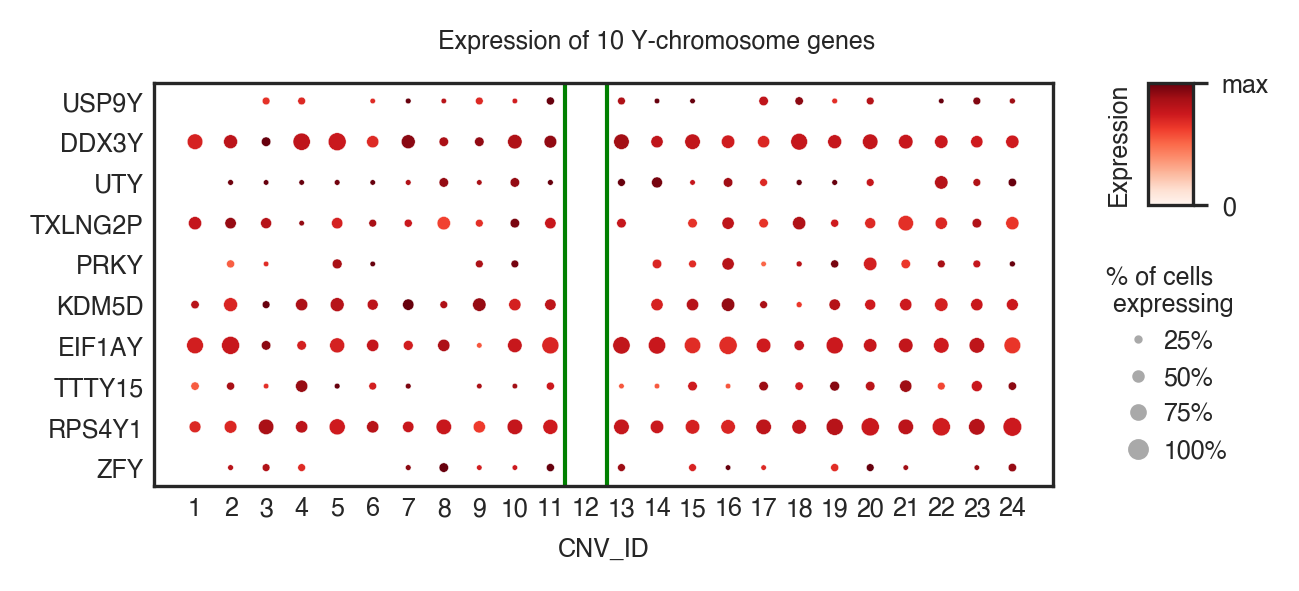

In [304]:
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

figsize=(110*mm, 50*mm)

fig = plt.figure(constrained_layout=False, figsize=figsize, dpi=300)
#                 gridspec_kw={'wspace':0.1, 'width_ratios':[15,1]})
gs = fig.add_gridspec(2,2, wspace=0.2, width_ratios=[20,1], height_ratios=[1,2])

ax = fig.add_subplot(gs[:,0])
ax_cb = fig.add_subplot(gs[0,1])
ax_ci = fig.add_subplot(gs[1,1])


#fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300, 
#                      gridspec_kw={'wspace':0.1, 'width_ratios':[15,1]})
sns.set_style('white')
setfontsize()

genes_Y_pl = [gene for gene in genes_Y if gene[:4] != 'RNA5']
genes_Y_pl = [gene for gene in genes_Y_pl if adata['sc'].to_df()[gene].max() > np.log1p(10)]

gp_means = adata['sc'].to_df().groupby(adata['sc'].obs['CNV_ID'])[genes_Y_pl].mean()
gp_maxes = adata['sc'].to_df()[genes_Y_pl].max()
gp_nmeans = gp_means / gp_maxes
plot_df = pd.DataFrame(gp_nmeans.melt(ignore_index=False))
plot_df.columns = ['Gene','Mean']
plot_df['CNV_ID'] = plot_df.index
plot_df['NZ_frac'] = 0
plot_df['NZ_frac'] = adata['sc'].to_df().groupby(
    adata['sc'].obs['CNV_ID'])[genes_Y_pl].apply(
    lambda col : (col > np.log1p(10)).sum() / len(col)).melt(
    ignore_index=False).value
plot_df['NZ_mean'] = plot_df['Mean'] / plot_df['NZ_frac']

#display(plot_df)

sns.scatterplot(x='CNV_ID', y='Gene', hue='NZ_mean', size='NZ_frac', 
                sizes=(0,20), hue_norm=(0,1), palette='Reds',
                data=plot_df, legend=False, ax=ax)

ax.set_ylabel('')
ax.tick_params(axis='both', pad=-1)

ax.axvline(11.6, color='green', linewidth=1.0)
ax.axvline(10.4, color='green', linewidth=1.0)


cmap = mpl.cm.Reds
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax_cb, orientation='vertical', label='Expression', shrink=0.6,
            ticks=[0,1])
cbar.ax.set_yticklabels(['0','max'])
cbar.ax.yaxis.set_label_position('left')
#cbar.ax.set_location('left')

for axis in [ax_cb, ax_ci]:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.spines['bottom'].set_visible(False)

msizes = np.array([1,2,3,4,5])

l1, = plt.plot([],[], 'or', markersize=msizes[0], color='darkgray')
l2, = plt.plot([],[], 'or', markersize=msizes[1], color='darkgray')
l3, = plt.plot([],[], 'or', markersize=msizes[2], color='darkgray')
l4, = plt.plot([],[], 'or', markersize=msizes[3], color='darkgray')

labels = ['25%','50%','75%','100%']

leg = ax_ci.legend(handles=[l1, l2, l3, l4], labels=labels, ncol=1, frameon=False, handletextpad=0,
                  title='% of cells \n expressing', loc='center')

ax_ci.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, pad=-1)
plt.suptitle('Expression of 10 Y-chromosome genes')
set_size(fig, (figsize))
plt.savefig('Panels/Dotplot_LoY.pdf', bbox_inches='tight')
plt.show()

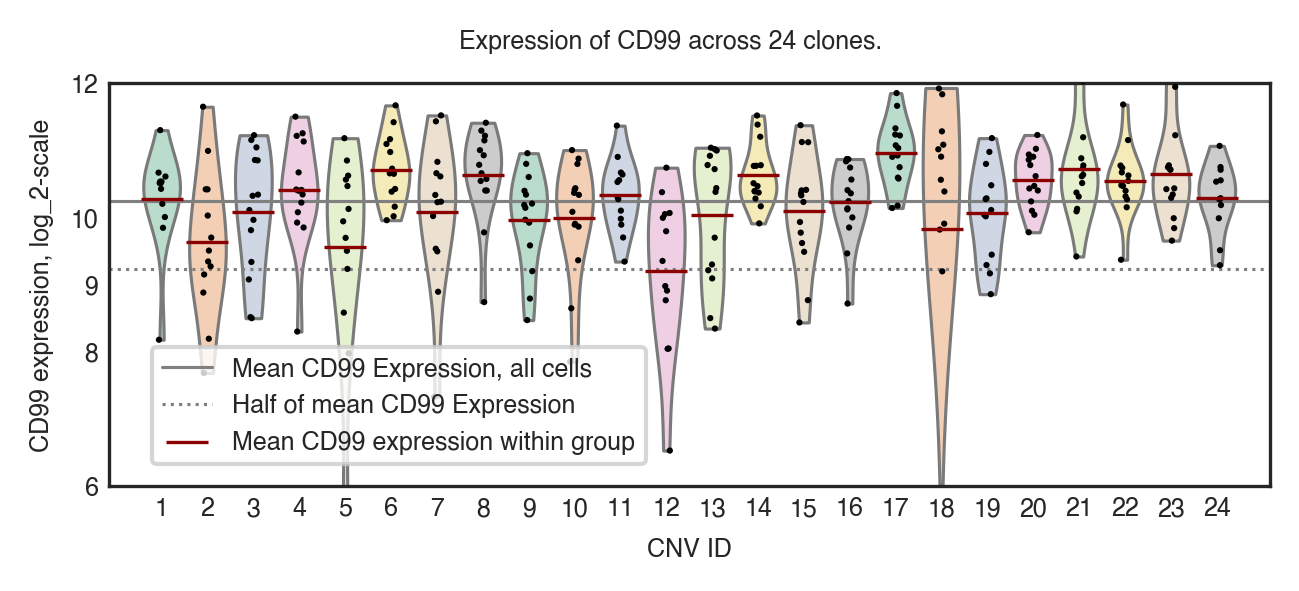

In [340]:
XY_gene = 'CD99'

figsize=(110*mm, 50*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('white')
setfontsize()



adXY = adata['sc'].copy()
adXY.X = adXY.to_df() / np.log(2)

sc.pl.violin(adXY, [XY_gene], groupby='CNV_ID', size=1.5, linewidth=0.75,
             palette=sns.color_palette("Pastel2"), ax=ax, show=False)
#ax.set_ylim((5,9))
CNV_means = adXY.to_df().groupby(adata['sc'].obs.CNV_ID)[XY_gene].mean()
all_mean = adXY.to_df()[XY_gene].mean()
single_mean = CNV_means['12']

ax.axhline(all_mean, color='gray', label='Mean {} Expression, all cells'.format(XY_gene), linewidth=0.75)
ax.axhline(all_mean - 1, color='gray', linestyle=':', label='Half of mean CD99 Expression', linewidth=0.75)

sns.scatterplot(CNV_means.index, CNV_means.values, color='darkred', 
                marker='_', s=100, zorder=5, label='Mean CD99 expression within group')

ax.set_ylabel('{} expression, log_2-scale'.format(XY_gene))
ax.set_yticks([6,8,9,10,12])

ax.tick_params(axis='both', pad=-1)
ax.legend(bbox_to_anchor=(0.25,.2), loc='center')
plt.suptitle('Expression of {} across 24 clones.'.format(XY_gene))
set_size(fig, figsize)
plt.savefig('Panels/CD99_LoY.pdf', bbox_inches='tight')
plt.show()

In [319]:
adata['sc'].obs[adata['sc'].obs.CNV_ID == '12']

,Cell_Number,Clone_ID,Condition,Day,In_Vivo_Clone_ID,Project_ID,Well_ID,log1p_n_genes_by_counts,log1p_total_counts,log1p_total_counts_mt,n_genes,n_genes_by_counts,obs_names,pct_counts_mt,total_counts,total_counts_mt,CloneWell,CNV_ID
obs_names,,,,,,,,,,,,,,,,,,
P3128_1369,1.0,14,In_Vitro,NaN,14.0,P3128,F11,7.886833,9.402554,5.097280,2661,2661,P3128_1369,1.341578,12118.285156,162.576263,14_F11,12
P3128_1370,1.0,14,In_Vitro,NaN,14.0,P3128,F11,7.881937,9.375041,5.152620,2648,2648,P3128_1370,1.457952,11789.405273,171.883820,14_F11,12
P3128_1371,1.0,14,In_Vitro,NaN,14.0,P3128,F11,8.090096,9.548151,5.184228,3261,3261,P3128_1371,1.265793,14017.753906,177.435730,14_F11,12
P3128_1372,1.0,14,In_Vitro,NaN,14.0,P3128,F11,7.813187,9.359448,5.118992,2472,2472,P3128_1372,1.431611,11606.980469,166.166855,14_F11,12
P3128_1373,1.0,14,In_Vitro,NaN,14.0,P3128,F11,8.093462,9.566295,5.138300,3272,3272,P3128_1373,1.186919,14274.425781,169.425903,14_F11,12
P3128_1374,1.0,14,In_Vitro,NaN,14.0,P3128,F11,7.974533,9.461717,5.183941,2905,2905,P3128_1374,1.379679,12856.937500,177.384491,14_F11,12
P3128_1375,1.0,14,In_Vitro,NaN,14.0,P3128,F11,8.110427,9.519825,5.176215,3328,3328,P3128_1375,1.291712,13626.223633,176.011520,14_F11,12
P3128_1377,1.0,14,In_Vitro,NaN,14.0,P3128,F11,8.076205,9.592354,5.113726,3216,3216,P3128_1377,1.128149,14651.314453,165.288712,14_F11,12
P3128_1378,1.0,14,In_Vitro,NaN,14.0,P3128,F11,7.863267,9.373810,5.070020,2599,2599,P3128_1378,1.343346,11774.888672,158.177505,14_F11,12


,Well
obs_names,
P3128_1193,D2
P3128_1194,D2
P3128_1195,D2
P3128_1197,D2
P3128_1198,D2
...,...
P3128_1569,H4
P3128_1570,H4
P3128_1571,H4


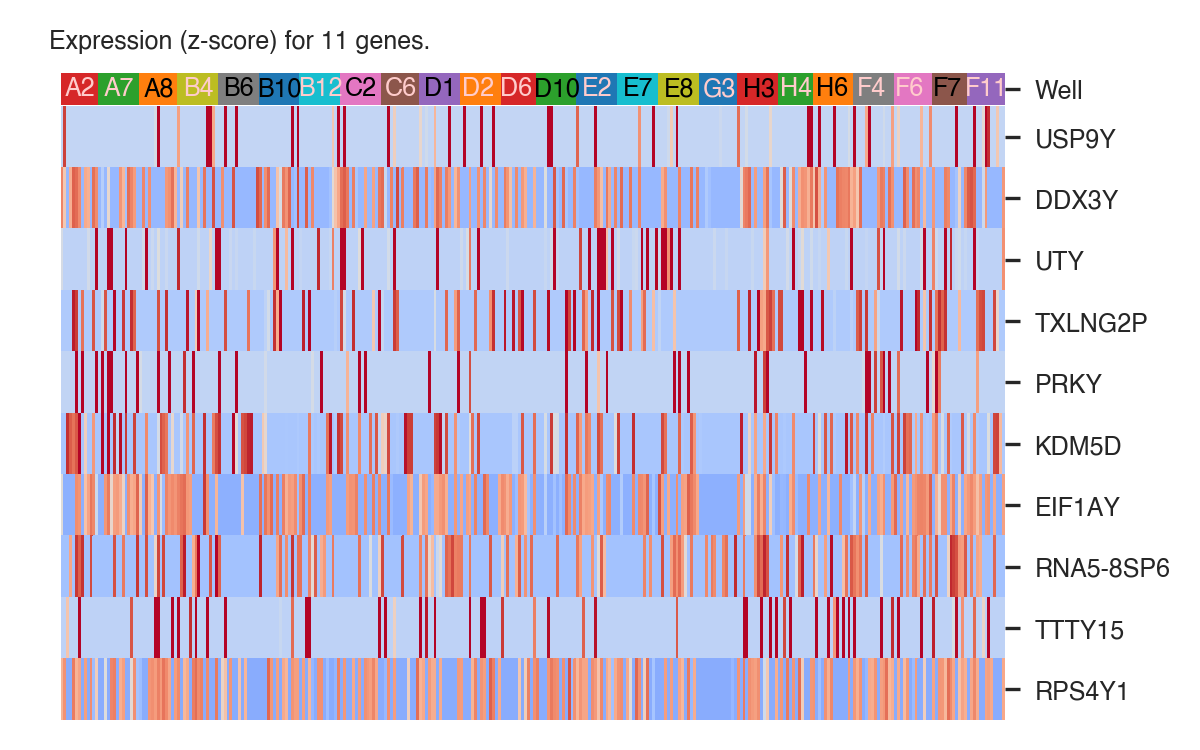

In [170]:
classminiheat(X, y_well, genes_Y, classlist = welllist, filename='Panels/fig2_Y_heatmap.pdf')

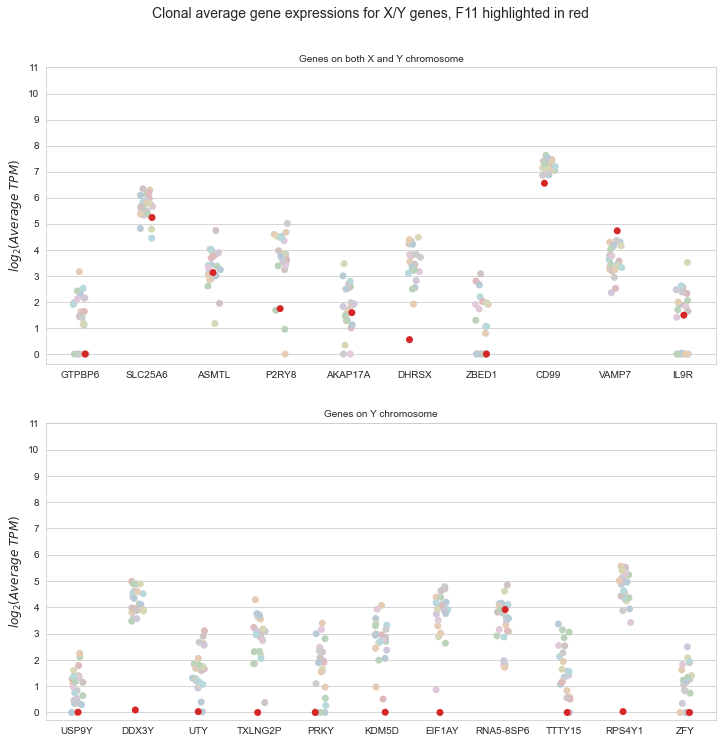

In [171]:
desetfontsize()
sns.set_style('whitegrid')
fig,ax = plt.subplots(2,1,figsize=(12,12))

pal = sns.color_palette(n_colors=len(welllist))
pal = [np.multiply(0.2,c) + (0.7,0.7,0.7) for c in pal[:-1]] + [pal[-1]]
lut = dict(zip(welllist, pal))

for j,genelist in enumerate([genes_XY, genes_Y]):
    plot_df = (2**X[genelist] - 1).groupby(y_well).mean()
    plot_df = np.log(plot_df + 1) / np.log(2)
    plot_df = plot_df.reindex(welllist)
    #plot_df.columns = plot_df.columns.map(gene_names)
    plot_df['Clone'] = plot_df.index
    plot_df = plot_df.melt(id_vars = ['Clone'])
    plot_df.columns = ['Clone', 'Gene', 'Ave TPM']
    plot_df['Clone F11'] = (plot_df['Clone']=='F11')
    sns.stripplot(x='Gene', y='Ave TPM', hue='Clone', data=plot_df, palette = lut, ax=ax[j], s=7)
    ax[j].set_xlabel('')
    ax[j].set_ylabel('$log_2(Average \ TPM)$')
    ax[j].set_yticks(range(0,12))
    ax[j].legend().remove()
    
    
ax[0].set_title('Genes on both X and Y chromosome')
ax[1].set_title('Genes on Y chromosome')
plt.suptitle('Clonal average gene expressions for X/Y genes, F11 highlighted in red', y=0.95)
plt.show()

,Well
obs_names,
P3128_1193,D2
P3128_1194,D2
P3128_1195,D2
P3128_1197,D2
P3128_1198,D2
...,...
P3128_1569,H4
P3128_1570,H4
P3128_1571,H4


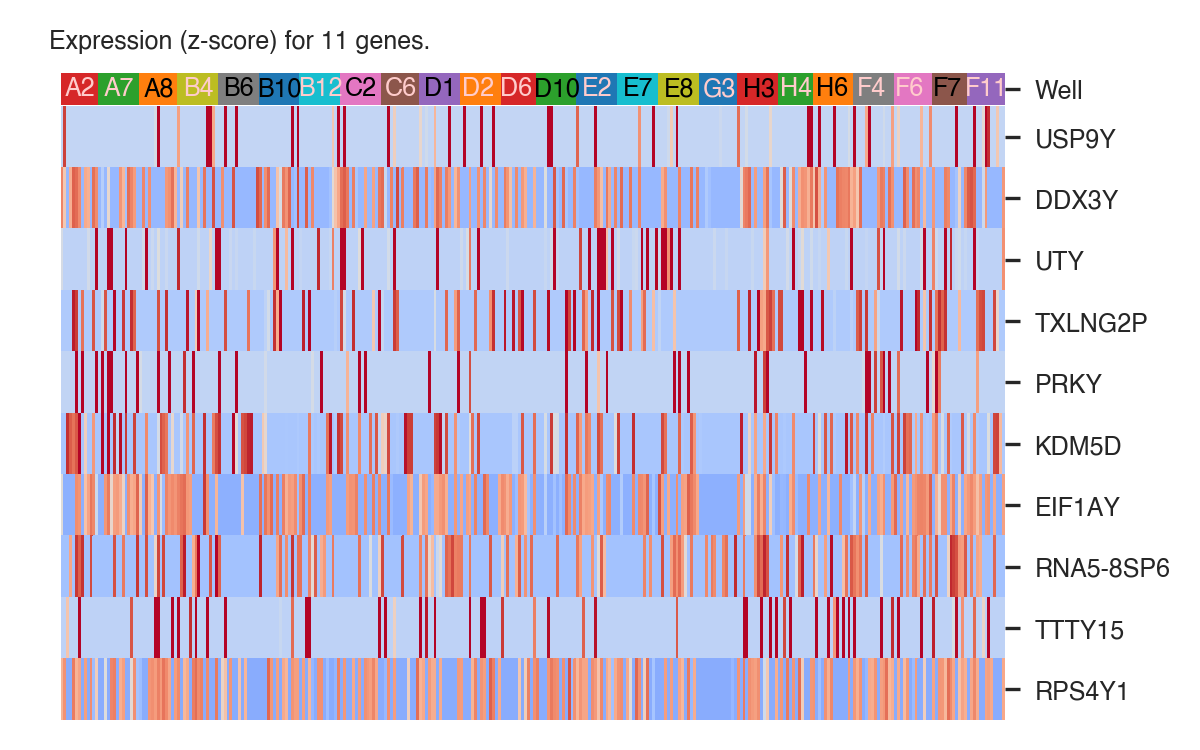

In [172]:
classminiheat(X, y_well, genes_Y, classlist = welllist, filename='Panels/Y_heatmap.pdf')

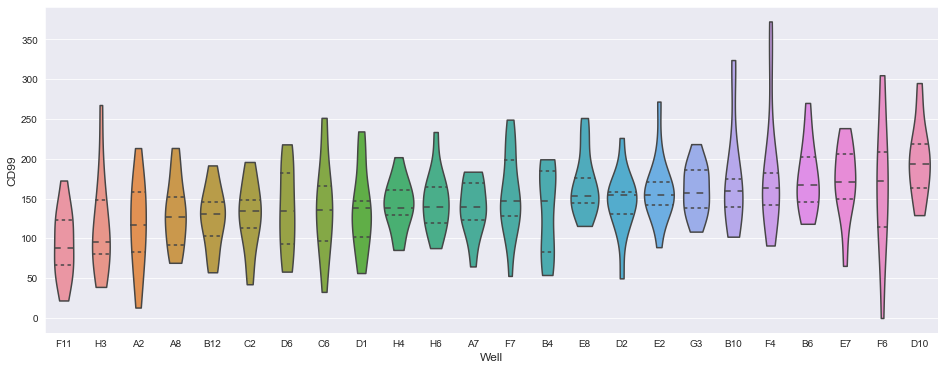

In [173]:
desetfontsize()
sns.set_style('darkgrid')
fig,ax = plt.subplots(figsize=(16,6))
plot_df = pd.DataFrame(index = X.index)
plot_df['CD99'] = 2**X['CD99'] - 1
plot_df['Well'] = y_well
wellmeans = plot_df.groupby('Well').median().sort_values('CD99')
sns.violinplot(x='Well', y='CD99', order = wellmeans.index, inner='quartile', data=plot_df, cut=0)
plt.show()

# SVM classification applied to clones and wells

## General-purpose visualizations

In [22]:
def CV_map(gs, swap=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))

In [23]:
def confusion_matrix(X,y,pipe, reps=2, classlist = None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    
    f, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(valid, annot=valid, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.046, 'pad':0.04}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, .25, .5, .75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_ylabel("Actual class")
    ax.set_xlabel("Predicted class")
    ax.set_title("Overall prediction accuracy {:0.3%}. \n"
                 "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

## SVM Classification, 20 clones.

In [51]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = [2,5,10,20,30,50,75,100,125,150,200,250,300], svm__C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y_clone)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [2, 5, 10, 20, 30, 50, 75, 100, 125, 150,
                                    200, 250, 300],
                         'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})

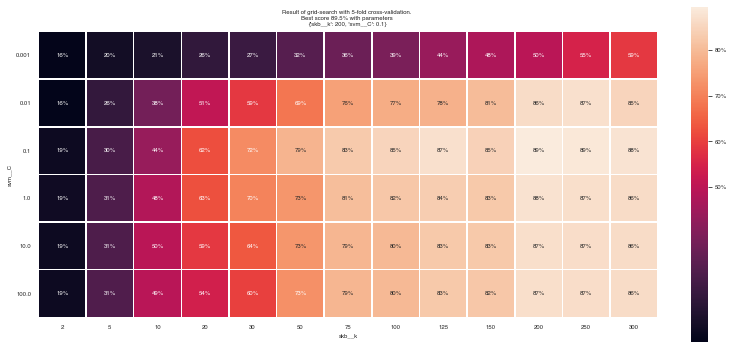

In [52]:
CV_map(grid_search, swap=True)

## Panel:  Confusion matrix, 20 clones.

In [53]:
def confusion_matrix(X,y,pipe, reps=2, classlist = None, filename=None, figsize=(65*mm,65*mm)):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    valid_dec = (valid*100).astype(int)
    
    #f, ax = plt.subplots(figsize=(8,7))
    f, ax = plt.subplots(figsize=figsize, dpi=300)
    setfontsize()
    #fmt="2.0%"
    sns.heatmap(valid, annot=valid_dec, annot_kws={'fontsize':5}, fmt="d", square=True, linewidths=.25, cbar=None,
                cbar_kws={'fraction':0.02, 'pad':0.02}, ax=ax)
    #cbar = ax.collections[0].colorbar
    #cbar.set_ticks([0, .25, .5, .75, 1])
    #cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    #ax.set_xticks([1,2,3,4])
    #ax.set_yticks([1,2,3,4])
    tickypos = -0.3
    
    pal = sns.color_palette(n_colors=len(classes))
    pal = pal[-1::-1]
    lut = dict(zip(classes, pal))
    
    for j,cl in enumerate(classes):
        ax.add_patch(Rectangle((tickypos,j+0.1),0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,tickypos),0.8,0.3, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((len(classes)-tickypos,j+0.1),-0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,len(classes)-tickypos),0.8,-0.3, color=lut[cl],fill=True,clip_on=False))
        
    ax.add_patch(Rectangle((16,20-tickypos), 4-tickypos, -4+tickypos, color='red', fill=False, 
                           clip_on=False, linestyle='--'))
    ax.set_ylabel("Actual clone")
    ax.set_xlabel("Predicted clone")
    ax.set_title("Overall accuracy {:1.0%} with {} clones".format(correct / total, len(classes)))
    ax.tick_params(axis='both', which='major', pad=-tickypos)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)
    
    if filename:
        set_size(f, figsize)
        plt.savefig(filename, bbox_inches='tight')
    # "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

We custom-order the clones for this figure, and double-check we didn't mess up the list.

In [24]:

clones_ordered = ['3', '6', '7', '8', '9', '12' , '14', '18', '27', '29', '32',
          '41',  '44', '47','48', '55','1', '13', '11', '54']

print(len(clones_ordered) == len(clones))
print(set(clones_ordered) == set(clones))

True
True


In [55]:
opt_k = grid_search.best_params_['skb__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['svm__C'] # Use optimal C-parameter for linear SVM.
print(opt_k, opt_C)

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))


200 0.1


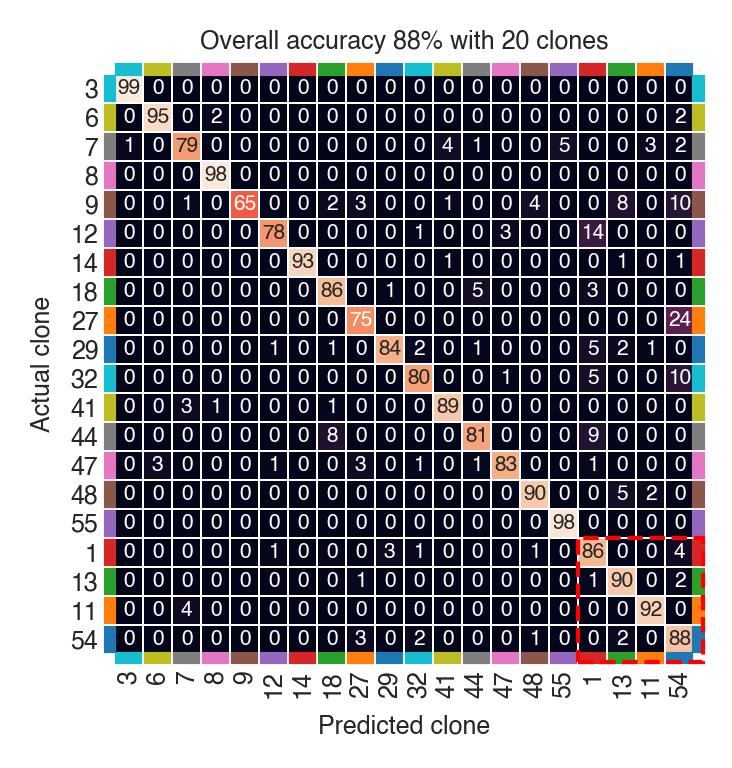

In [56]:
confusion_matrix(X,y_clone, SVMpipe, reps=100, classlist = clones_ordered, filename='Panels/Confusion.pdf')

In [25]:
y_clone.value_counts()

54    33
13    28
1     27
11    20
29    14
48    14
55    14
47    14
32    14
18    14
6     14
12    14
8     14
41    14
44    13
9     13
7     13
14    13
3     12
27    12
Name: Clone_ID, dtype: int64

## SVM Prediction, Sister clones only

Here we use clones from one set of wells to predict clonality from other wells.

In [26]:
clones_sis=['1','13','11','54']
y_sis = y_clone[y_clone.isin(clones_sis)]
cells_sis = y_sis.index

y_sis_cw = adata['sc'].obs.loc[cells_sis].CloneWell.astype(str)
clonewells = ['1_A8','1_E2','13_B12','13_E7','11_H3','11_H4','54_H4','54_B4','54_B10'] # Custom order

if set(clonewells) != set(y_sis_cw.unique()):
    print('Error matching clone/well combos.')

X_sis = X.loc[cells_sis]

In [27]:
y_sis_cw

obs_names
P3128_1209    11_H3
P3128_1210    11_H3
P3128_1211    11_H3
P3128_1212    11_H3
P3128_1213    11_H3
              ...  
P3128_1569    54_H4
P3128_1570    11_H4
P3128_1571    11_H4
P3128_1572    11_H4
P3128_1574    54_H4
Name: CloneWell, Length: 108, dtype: object

In [28]:
y_sis_cw.value_counts()

13_E7     14
54_B10    14
13_B12    14
1_E2      14
54_B4     14
1_A8      13
11_H3     13
11_H4      7
54_H4      5
Name: CloneWell, dtype: int64

In [29]:
pd.DataFrame([cw.split('_') for cw in y_sis_cw], columns=['Clone','Well'], index=y_sis_cw.index)

,Clone,Well
obs_names,,
P3128_1209,11,H3
P3128_1210,11,H3
P3128_1211,11,H3
P3128_1212,11,H3
P3128_1213,11,H3
...,...,...
P3128_1569,54,H4
P3128_1570,11,H4
P3128_1571,11,H4


This is where we implement a custom split -- assigning one well to the training set and another well to the testing set -- within each clone.  But the split well is required to end up in the testing set every time, to avoid problems.

In [30]:
def custom_split(X,y):
    cw_df = pd.DataFrame([cw.split('_') for cw in y_sis_cw], columns=['Clone','Well'], index=y_sis_cw.index)
    cells_train = []
    for clone in cw_df.Clone.unique():
        clone_df = cw_df[cw_df.Clone == clone]
        well_poss = clone_df.Well.unique()
        well_poss = [well for well in well_poss if clone_df.Well.value_counts()[well] > 10]
        well = np.random.choice(well_poss)
        cells_train += list(y[y == clone+'_'+well].index)
    cells_test = [cell for cell in X.index if cell not in cells_train]
    return X.loc[cells_train], X.loc[cells_test], cw_df.loc[cells_train]['Clone'], cw_df.loc[cells_test]['Clone']   

We try it once, to make sure it works.

In [63]:
X_train, X_test, y_train, y_test = custom_split(X_sis, y_sis_cw)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=100), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=1))

this_pipe = base.clone(SVMpipe)
this_pipe.fit(X_train, y_train)

y_pred = pd.Series(this_pipe.predict(X_test), index=X_test.index)
test_results = pd.DataFrame(columns=['Actual','Predicted'])
test_results['Actual'] = y_test
test_results['Predicted'] = y_pred
#display(test_results)
num_correct = (test_results['Actual'] == test_results['Predicted']).sum()
print('{:%} correct.'.format(num_correct / len(test_results)))

(54, 8663) (54,) (54, 8663) (54,)
75.925926% correct.


In [64]:
def custom_gridsearch(X,y, param_grid, no_reps):
    acc_array = np.zeros((len(param_grid['skb__k']), len(param_grid['svm__C'])))
    for rep in range(no_reps):
        X_train, X_test, y_train, y_test = custom_split(X,y)
        test_len = len(y_test)
        for i,k in enumerate(param_grid['skb__k']):
            for j,C in enumerate(param_grid['svm__C']):
                SVMpipe = make_pipeline(MinMaxScaler(), 
                                        SelectKBest(score_func = f_classif, k=k), 
                                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=C))

                this_pipe = base.clone(SVMpipe)
                this_pipe.fit(X_train, y_train)
                y_pred = pd.Series(this_pipe.predict(X_test), index=X_test.index)
                num_correct = (y_test == y_pred).sum()
                acc_array[i,j] += num_correct / test_len
    acc_array = acc_array / no_reps
    return pd.DataFrame(acc_array, index=param_grid['skb__k'], columns=param_grid['svm__C'])

In [65]:
param_grid = dict(skb__k = [2,5,10,20,30,50,75,100,125,150,200,250,300], 
                  svm__C = [0.001, 0.01, 0.1, 1.0, 10.0])

no_reps = 5

c_grid = custom_gridsearch(X_sis, y_sis_cw, param_grid, no_reps)

In [66]:
c_grid

,0.001,0.010,0.100,1.000,10.000
2,0.419637,0.415933,0.415933,0.415933,0.415933
5,0.471698,0.505730,0.524528,0.543047,0.550874
10,0.587491,0.643885,0.644095,0.647799,0.640042
20,0.655975,0.711461,0.726695,0.692872,0.681761
30,0.688959,0.696296,0.677638,0.666457,0.666387
50,0.753180,0.771488,0.767994,0.745632,0.753040
75,0.737876,0.782600,0.790426,0.775681,0.764430
100,0.737876,0.782739,0.767925,0.775542,0.779245
125,0.719008,0.778826,0.763941,0.763941,0.760238
150,0.730189,0.763871,0.775052,0.775122,0.775122


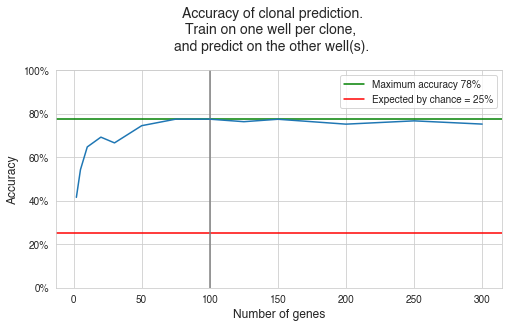

In [67]:
import matplotlib.ticker as mtick

desetfontsize()
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acc = c_grid[1.000]*100
acc_max = plot_acc.max()

ax.axhline(acc_max, label='Maximum accuracy {:.0%}'.format(acc_max/100), color='green')
ax.axhline(25, label='Expected by chance = 25%', color='red')
ax.axvline(100, color='gray')
ax.legend()
plt.plot(c_grid[1.000]*100)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of genes')
ax.set_ylim(0,100)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.suptitle('Accuracy of clonal prediction.\n'
             'Train on one well per clone, \n'
             'and predict on the other well(s).\n', y=1.1)

plt.show()

In [68]:
def confusion_matrix(X,y,pipe,splitter,no_reps=10,y_valuelist=None):
    if y_valuelist:
        y_vals = y_valuelist
    else:
        y_vals = y.unique()
    
    count_matrix = pd.DataFrame(0, index=y_vals, columns=y_vals)
    for t in range(no_reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = splitter(X,y)
        this_pipe.fit(X_train, y_train)
        y_pred = pd.Series(this_pipe.predict(X_test), index=X_test.index)
        test_results = pd.DataFrame(columns=['Actual','Predicted'])
        test_results['Actual'] = y_test
        test_results['Predicted'] = y_pred
        count_df = test_results.value_counts().unstack(level=1, fill_value=0)
        count_matrix += count_df
    return count_matrix

In [69]:
SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=200), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=1.0))

cm_df = confusion_matrix(X_sis, y_sis_cw, SVMpipe, 
                         no_reps=100, splitter=custom_split, y_valuelist=['1','13','11','54'])

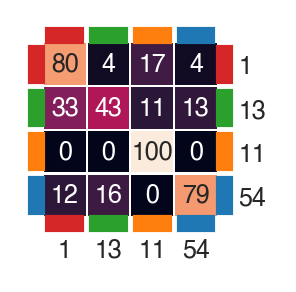

In [86]:
figsize=(25*mm,25*mm)
f, ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()
valid = (100 * cm_df / cm_df.sum(axis=1)).astype(np.int8)

sns.heatmap(valid, annot=valid, fmt="d", square=True, linewidths=.25, cbar=None,
            cbar_kws={'fraction':0.02, 'pad':0.02}, ax=ax)
tickypos = -0.3
pal = sns.color_palette(n_colors=len(clones_sis))
pal = pal[-1::-1]
lut = dict(zip(clones_sis, pal))

no_classes = len(clones_sis)

for j,cl in enumerate(clones_sis):
        ax.add_patch(Rectangle((tickypos,j+0.1),0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,tickypos),0.8,0.3, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((no_classes-tickypos,j+0.1),-0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,no_classes-tickypos),0.8,-0.3, color=lut[cl],fill=True,clip_on=False))        

ax.yaxis.tick_right()
#ax.set_yticks([])
#ax.set_xticks([])
ax.yaxis.set_label_position("right")
plt.yticks(rotation=0)
ax.set_ylabel('') #"Actual clone")
ax.set_xlabel('') #"Predicted clone", y=0.1)
#ax.set_title("Predicted clonality (%).", y=1.05)
ax.tick_params(axis='both', which='major', length=0, pad=5.0) #-tickypos)
    
set_size(f, figsize)
plt.savefig('Panels/Confusion_sisclones.pdf', bbox_inches='tight')

# Supplemental:  SVM Accuracy

In [71]:
k_testlist = list(range(1,10)) + list(range(10,20,2)) + list(range(20,40,5)) + list(range(40,90,10)) + list(range(100,200,25)) + list(range(200,400,50)) + list(range(400,801,100))

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y_clone)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(C=0.1, max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                    18, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100,
                                    125, 150, 175, 200, 250, 300, ...],
                         'svm__C': [0.1]})

In [72]:
SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=0.1, max_iter=2000)) ])

param_grid = dict(skb__k = k_testlist, svm__C = [0.1])

grid_search_shuff = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search_shuff.fit(X,yshuff_clone)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(C=0.1, max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16,
                                    18, 20, 25, 30, 35, 40, 50, 60, 70, 80, 100,
                                    125, 150, 175, 200, 250, 300, ...],
                         'svm__C': [0.1]})

In [73]:
CV_df = pd.DataFrame()
for split in range(5):
    split_string = 'split'+str(split)+'_test_score'
    CV_df[split] = grid_search.cv_results_[split_string]
CV_df['Number of genes'] = grid_search.cv_results_['param_skb__k'].data
CV_df['Clonal prediction accuracy'] = grid_search.cv_results_['mean_test_score']

CV_df.head()
CV_melt = pd.melt(CV_df, id_vars='Number of genes', value_vars=[0,1,2,3,4], value_name='Clonal prediction accuracy')
CV_shuff = pd.DataFrame()
CV_shuff['Number of genes'] = grid_search_shuff.cv_results_['param_skb__k'].data
CV_shuff['Clonal prediction accuracy'] = grid_search_shuff.cv_results_['mean_test_score']

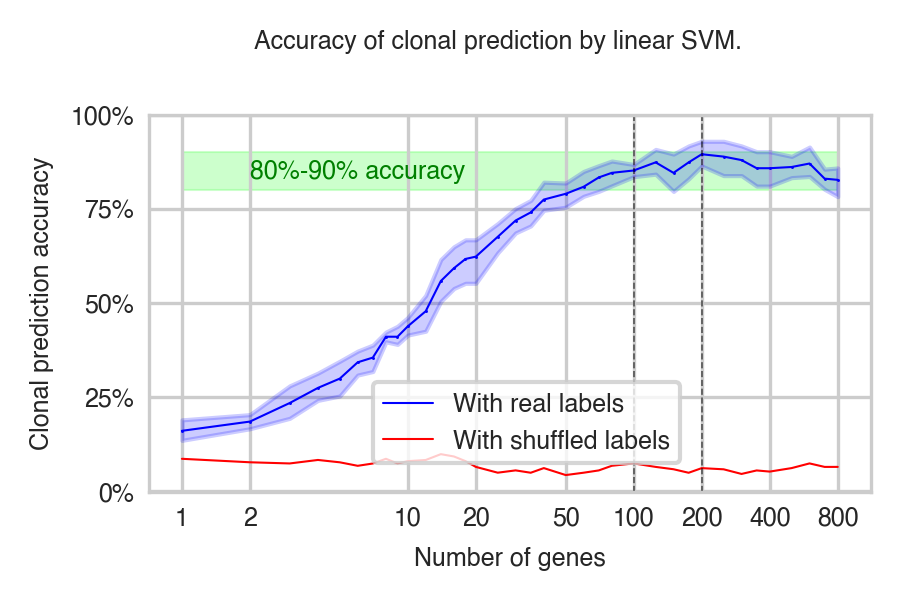

In [74]:
#fig,ax = plt.subplots(figsize = (20,6))
f, ax = plt.subplots(figsize=(3.0,2.0), dpi=300)


sns.set_style("white")
setfontsize()

sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_melt,
            color='blue', label='With real labels', linewidth=0.5)

sns.scatterplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_df, 
                color='blue', s=0.5, linewidth=0)

sns.lineplot(x = 'Number of genes', y = 'Clonal prediction accuracy', data=CV_shuff, 
             color='red', label='With shuffled labels', linewidth=0.5)

ax.set_xscale('log')
ax.set_yticks(np.linspace(0.0,1.0,5))

vals = ax.get_yticks()
ax.set_yticklabels(['{:1.0%}'.format(y) for y in vals])

ax.set_xticks([1,2,10,20,50,100,200,400,800])
vals = ax.get_xticks()
ax.set_xticklabels(['{}'.format(x) for x in vals])

ax.tick_params(axis='both', which='major', pad=0)

ax.add_patch(plt.Rectangle((1,0.8), 800, 0.1, zorder=-2, color=(0.5,1,0.5,0.4), linewidth=0.5))
ax.text(2, 0.83, '80%-90% accuracy', color='green')

ax.axvline(100, linestyle='--', linewidth=0.4, color='k', alpha=0.6) # vertical lines
ax.axvline(200, linestyle='--', linewidth=0.4, color='k', alpha=0.6) # vertical lines

plt.legend(bbox_to_anchor=(0.31, 0.29), loc=2, borderaxespad=0.)

plt.suptitle('Accuracy of clonal prediction by linear SVM.', y=1.05)# \n'
         #    'SVM penality parameter fixed at C = 0.1. \n'
         #   'Linear SVM restricted to {} -- {} most significant genes'.format(vals[0], vals[-1]), y=1.0)

set_size(f, (3.0, 2.0))
plt.savefig('Panels/SVM_graph.pdf', bbox_inches='tight')
    
plt.show()


# Heatmap, sister clones

In [31]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

wellmap = cm.get_cmap('Paired', 8)
wellmap.colors = wellmap.colors[[0,1,3,4,2,5,6,7]]

We look at the genes which are differentially expressed between clones -- just for the 4 sister clones 1,13,11,15.

In [32]:
F_pipe = Pipeline([ ('mm', MinMaxScaler()),
                    ('skb', SelectKBest(score_func = f_classif, k=120))])

F_pipe.fit(X_sis,y_sis)
skbf = F_pipe.named_steps['skb']

genes_sis = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(genes_sis),', '.join(genes_sis)))

The 120 differentially expressed genes (selected by ANOVA F) are: ISG15, RP11-465B22.3, TNFRSF18, TNFRSF4, ID3, RP1-159A19.3, DPYD, KIAA1324, CSF1, SLAMF7, SELL, IL24, FAIM3, LGALS8, KIF5B, SRGN, SPOCK2, TCTN3, ABLIM1, IFITM2, IFITM1, IFITM3, CD59, PPP1R14B, CTSC, SMCO4, AP000783.1, CD9, CD27, LAG3, KLRB1, KLRD1, KLRC1, IFNG, PHLDA1, PMCH, RPL21, GZMH, GZMB, RPS29, LGALS3, ACTN1, NUDT14, B2M, SHC4, RPLP1, PKM, ISG20, IDH2, IL32, GDE1, GPR56, ITGAE, GRN, HOXB2, CD7, TTC39C, CD70, FXYD7, ZBTB32, AC006129.4, EMP3, RPL13A, LAIR2, LILRB1, KIR2DL4, KIR2DL3, KIR2DS4, AC092580.4, CAPG, GNLY, RP11-1399P15.1, MIR4435-1HG, AC017002.1, GYPC, CCDC141, CD28, CTLA4, ITM2C, PTMA, PTGIS, MIR155HG, ITGB2-AS1, GGA1, APOBEC3C, APOBEC3G, SRGAP3, RP11-222K16.2, EOMES, CCR2, CD96, ZBED2, HPGDS, PPP1R14BP3, HPGD, ITGA1, GZMA, F2R, MZB1, TMEM173, HLA-DRB6, HLA-DMA, HLA-DPA1, FKBP5, FYN, MOXD1, SYTL3, PDGFA, ERI1, MSC, RP11-40C6.2, RPL10P3, NPDC1, MT-CO1, PIM2-1, FOXP3-1, ITM2A, CTD-2328D6.1, CD40LG, AC010970.2

Now we look at the genes that are differentially expressed for the cell and well combined.

In [33]:
F_pipe = Pipeline([ ('mm', MinMaxScaler()),
                    ('skb', SelectKBest(score_func = f_classif, k=200))])

F_pipe.fit(X_sis,y_sis_cw)
skbf = F_pipe.named_steps['skb']

genes_cw = list(compress(genes, skbf.get_support())) # differentially-expressed genes by ANOVA F
print('The {} differentially expressed genes (selected by ANOVA F) are: {}'.format(
    len(genes_cw),', '.join(genes_cw)))

The 200 differentially expressed genes (selected by ANOVA F) are: RP11-465B22.3, TNFRSF18, TNFRSF4, RP3-477M7.5, TNFRSF1B, ID3, STMN1, SH3BGRL3, CD52, RP1-159A19.3, ADC, GNL2, ATG4C, HS2ST1, DPYD, KIAA1324, CSF1, HIPK1, TTF2, RPRD2, RPS27, PYGO2, UBQLN4, SLAMF7, SELL, GLUL, IL24, FAIM3, SNAP47, LGALS8, KIF5B, SRGN, SPOCK2, ACTA2, ENTPD1, ABLIM1, IFITM2, IFITM1, IFITM3, RRM1, TRIM22, CD59, COMMD9, MADD, CLP1, PPP1R14B, CTSW, CTSC, AP000783.1, CD9, CD27, LPAR5, LAG3, KLRB1, CLECL1, KLRD1, KLRC3, KLRC1, HNRNPA1, RPL41, IFNG, PHLDA1, PMCH, ZNF140, RPL21, ALOX5AP, GPR183, GZMH, GZMB, RPS29, GNPNAT1, LGALS3, MTHFD1, C14orf64, NUDT14, B2M, SHC4, RPLP1, PKM, ISG20, IDH2, LRRC28, KCTD5, IL32, GDE1, GPR56, ITGAE, UBB, AKAP10, LGALS9, TMUB2, GRN, HOXB2, CD79B, ICAM2, SYNGR2, CD7, MYL12A, TTC39C, CD70, FXYD7, ZBTB32, RPS19, RPL13A, LAIR2, LILRB1, KIR2DL4, KIR2DL3, KIR2DS4, AC092580.4, FAM49A, PLEK, ARHGAP25, CAPG, GNLY, RP11-1399P15.1, MIR4435-1HG, AC017002.1, GYPC, CCDC141, CD28, CTLA4, ITM2C, PT

In [34]:
clonewells

['1_A8',
 '1_E2',
 '13_B12',
 '13_E7',
 '11_H3',
 '11_H4',
 '54_H4',
 '54_B4',
 '54_B10']

In [35]:
# Create colors for clones (or whatever classes)
pal = sns.color_palette(n_colors=len(clones_sis))
pal = pal[-1::-1]
cs_lut = dict(zip(clones_sis, pal))
cs_lut

{'1': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 '13': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 '11': (1.0, 0.4980392156862745, 0.054901960784313725),
 '54': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)}

In [36]:
def darken(rgb):
    r,g,b = rgb
    rgb_dark = (0.5*r, 0.5*g, 0.5*b)
    return rgb_dark

def lighten(rgb):
    r,g,b = rgb
    rgb_dark = (0.5*r + 0.5, 0.5*g + 0.5, 0.5*b + 0.5)
    return rgb_dark

def av_col(rgb, RGB):
    r,g,b = rgb
    R,G,B = RGB
    return (0.5*(r+R), 0.5*(g+G), 0.5*(b+B))

In [37]:
cw_lut = {}
well_lut = {}

j = 0
for cw in clonewells:
    j = (j+1)%2
    clone = cw.split('_')[0]
    well = cw.split('_')[1]
    base_col = cs_lut[clone]
    if j == 0:
        cw_lut[cw] = darken(base_col)
    else:
        cw_lut[cw] = lighten(base_col)
    if cw != '54_H4':
        well_lut[well] = cw_lut[cw]
        
cw_lut['54_H4'] = av_col(cs_lut['11'],cs_lut['54'])

cw_lut

{'1_A8': (0.919607843137255, 0.5764705882352941, 0.5784313725490196),
 '1_E2': (0.4196078431372549, 0.07647058823529412, 0.0784313725490196),
 '13_B12': (0.5862745098039216, 0.8137254901960784, 0.5862745098039216),
 '13_E7': (0.08627450980392157, 0.3137254901960784, 0.08627450980392157),
 '11_H3': (1.0, 0.7490196078431373, 0.5274509803921569),
 '11_H4': (0.5, 0.24901960784313726, 0.027450980392156862),
 '54_H4': (0.5607843137254902, 0.4823529411764706, 0.38039215686274513),
 '54_B4': (0.060784313725490195, 0.23333333333333334, 0.35294117647058826),
 '54_B10': (0.5607843137254902, 0.7333333333333334, 0.8529411764705883)}

In [38]:
well_lut

{'A8': (0.919607843137255, 0.5764705882352941, 0.5784313725490196),
 'E2': (0.4196078431372549, 0.07647058823529412, 0.0784313725490196),
 'B12': (0.5862745098039216, 0.8137254901960784, 0.5862745098039216),
 'E7': (0.08627450980392157, 0.3137254901960784, 0.08627450980392157),
 'H3': (1.0, 0.7490196078431373, 0.5274509803921569),
 'H4': (0.5, 0.24901960784313726, 0.027450980392156862),
 'B4': (0.060784313725490195, 0.23333333333333334, 0.35294117647058826),
 'B10': (0.5607843137254902, 0.7333333333333334, 0.8529411764705883)}

In [39]:
wells_sis = list(well_lut.keys())

In [88]:
def sort_by(df, vs, valuelist):
    '''
    Sorts a data frame, according to the values in a series,
    and a chosen order for these values.
    '''
    if set(vs.unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = vs.apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df


def miniheat(ef, mf, genelist, filename=None, hpush = 0, use_markers=True, genelabel = False):
    '''
    Visualizes gene expression across cells.
    
    Args:
        ef (pandas dataframe):  The gene expression matrix.
        mf (pandas dataframe:  The metadata dataframe.
        genelist (list): The list of genes to visualize.
        prop:  A column of the metadata, e.g. Clone_ID.  Place cells in blocks according to this.
        classlist:  Custom sort Clone_ID (or whatever prop) according to this list.
        filename:  If given, the filename to save the figure, e.g. 'heatmap.pdf'
        
    Returns:
        None.  Just makes a pretty picture.
        
    
    '''
    genelist = [gene for gene in genelist if gene in ef.columns]
    df = ef[genelist].copy()
    
    md = pd.DataFrame(index=mf.index)
    md['CloneWell'] = mf
    df = sort_by(df, md['CloneWell'], clonewells)
    md = sort_by(md, md['CloneWell'], clonewells)
    
    md['Clone'] = [cw.split('_')[0] for cw in md['CloneWell']]
    md['Well'] = [cw.split('_')[1] for cw in md['CloneWell']]
    
    # Sort genes by markers of clones.
    if use_markers:
        marker_list = []
        df_cl = df.groupby(md['CloneWell']).mean()
        for cl in clonewells:
            markers = [gene for gene in genelist if df_cl[gene].max() == df_cl[gene][cl]]
            marker_list += markers
        genelist = marker_list
    
    #df_cl = df.groupby(md['Clone']).mean()
    #for cl in clones_sis:
    #    markers = [gene for gene in genelist if df_cl[gene].max() == df_cl[gene][cl]]
    #    marker_list += markers
    #genelist = marker_list
    df = df[genelist]
    
    # Create plot.
    
    # Set (small) figure size and fonts
    figsize=(55*mm, 75*mm)
    
    sns.set_style("white")
    setfontsize()
    
    
    # Create colors for clones (or whatever classes)
    #pal = sns.color_palette(n_colors=len(clones_sis))
    #pal = pal[-1::-1]
    #lut = dict(zip(clones_sis, pal))
    colors = pd.DataFrame(index=df.index)
    colors['Clone'] = md['Clone'].map(cs_lut)
    
    # Custom well palette.  Note H4 is shared by two clones, so special color is used.
    #wellpalette = {'A8':'k', 'E2':'y', 'B12':'k', 'E7':'y', 'H3':'k', 'H4':'pink', 'B4':'k', 'B10':'y'}
    
    #wells = md['Well'].unique()
    #well_pal = sns.cubehelix_palette(len(wells),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    #well_pal = wellmap.colors
    #well_lut = dict(zip(wells, well_pal))
    colors['Well'] = md['Well'].map(well_lut)
    
    cg = sns.clustermap(df.transpose(), z_score=0, cmap="coolwarm", vmin=-2, vmax=2, 
                        col_colors=colors, figsize=figsize, col_cluster=False, row_cluster=False,
                        dendrogram_ratio=(0.01,0.01), colors_ratio=0.05, cbar_pos = None)
        
    
    cg.fig.set_dpi(300)
    #cg.cax.set_position([0.75+hpush, .3, .02, .4]) # Colorbar.
    
    ax = cg.ax_heatmap # Main heatmap axis.
    if genelabel == False:
        ax.set_yticks([])
    ax.set_ylabel('')
    ytl = ax.get_yticklabels()
    #ax.set_yticklabels([gene_names[gene.get_text()] for gene in ytl])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_xticklabels([])
    cut_loc = len(md[md['Clone'] != '54'])
    ax.axvline(cut_loc + 0.5, color='k', linewidth=0.5)
    cut_loc = len(md[md['Clone'] == '1'])
    ax.axvline(cut_loc + 0.5, color='k', linewidth=0.5)
    cut_loc = len(md[(md['Clone'] == '1') | (md['Clone'] == '13')])
    ax.axvline(cut_loc + 0.5, color='k', linewidth=0.5)

    # Clone labels
    j = 0
    for clone in clones_sis:
        no_label = len(md[md['Clone'] == clone])
        #if np.mean(lut[clone]) < 0.5: # Dark colors get light labels.
        #textcolor = (1,1,1)
        #else: # Light colors get dark labels.
        textcolor = (0,0,0)   
        j += no_label / 2
        cg.ax_col_colors.text(j,0.7,clone, color=textcolor, ha='center')
        j += no_label / 2
        
    j = 0
    for well in wells_sis:
        no_label = len(md[md['Well'] == well])
        if np.mean(well_lut[well]) < 0.5: # Dark colors get light labels.
            textcolor = (1,1,1)
        else: # Light colors get dark labels.
            textcolor = (0,0,0)   
        j += no_label / 2
        cg.ax_col_colors.text(j,1.7,well, color=textcolor, ha='center')
        j += no_label / 2
    
    
    # Figure title
    figtitle = '{} genes, 4 clones in 8 wells'.format(len(genelist))
    plt.suptitle(figtitle, ha='left', x=0.1, y=0.99)   
    
    if filename:
        #plt.savefig(filename, pad_inches = 0, dpi = 300)
        set_size(cg.fig, (50*mm, 70*mm))
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

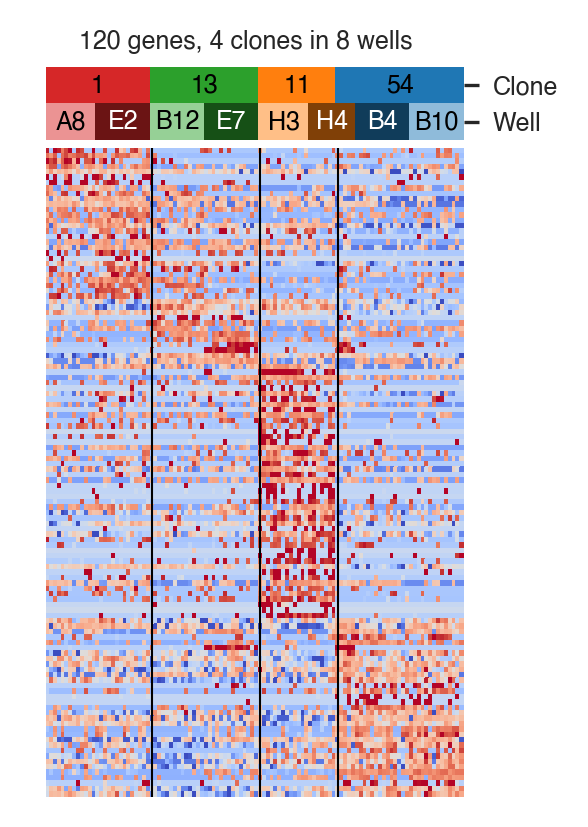

In [43]:
miniheat(X_sis, y_sis_cw, genes_sis, filename='Panels/Heatmap.pdf')

In [46]:
def ANOVA_p(X,y):
    args = [X[y == k] for k in np.unique(y)]
    pvals = f_oneway(*args)[1] # Use f_oneway for high precision.
    return pd.Series(pvals, index=X.columns, name='pval') # Built-in ANOVA F from scikit.

In [94]:
Fp_sis = ANOVA_p(X_sis, y_sis)
sig_sisgenes = Fp_sis[Fp_sis < 1e-3].index
len(sig_sisgenes)

199

In [96]:
Fp = ANOVA_p(X, y_clone)
sig_genes = Fp[Fp < 1e-3].index
len(sig_genes)

486

In [97]:
markers_13 = [gene for gene in sig_genes if X[gene].groupby(y_clone).mean().idxmax() == '13']
print(markers_13)

['CTSW', 'CTSC', 'KLRC1', 'KIR2DL3', 'KIR2DS4', 'GNLY', 'PAX8-AS1', 'ITGB2', 'EOMES']


In [98]:
markers_13_sis = [gene for gene in sig_sisgenes if X_sis[gene].groupby(y_sis).mean().idxmax() == '13']
print(markers_13_sis)

['CTSW', 'CTSC', 'KLRC1', 'HOXB2', 'CD70', 'LAIR2', 'LILRB1', 'KIR2DL3', 'KIR2DS4', 'GNLY', 'ITGB2', 'EOMES', 'GZMA', 'F2R', 'SAMD3', 'PDE7B', 'AOAH', 'PLS3-1', 'LDOC1-1']


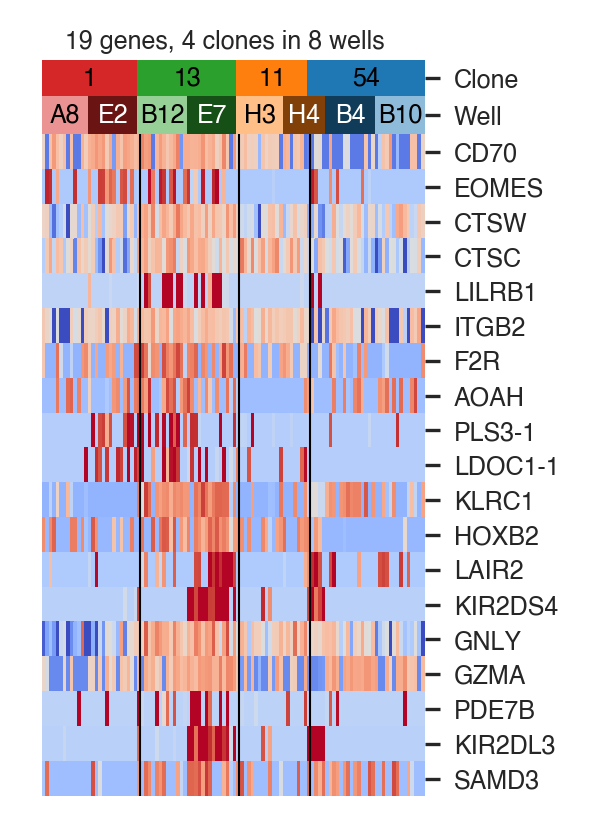

In [99]:
miniheat(X_sis, y_sis_cw, markers_13_sis, filename='Panels/Heatmap_13.pdf', genelabel=True)

In [108]:
y_clonewell

obs_names
P3128_1193     3_D2
P3128_1194     3_D2
P3128_1195     3_D2
P3128_1197     3_D2
P3128_1198     3_D2
              ...  
P3128_1569    54_H4
P3128_1570    11_H4
P3128_1571    11_H4
P3128_1572    11_H4
P3128_1574    54_H4
Name: CloneWell, Length: 324, dtype: object

Warning, cannot sort!
Warning, cannot sort!


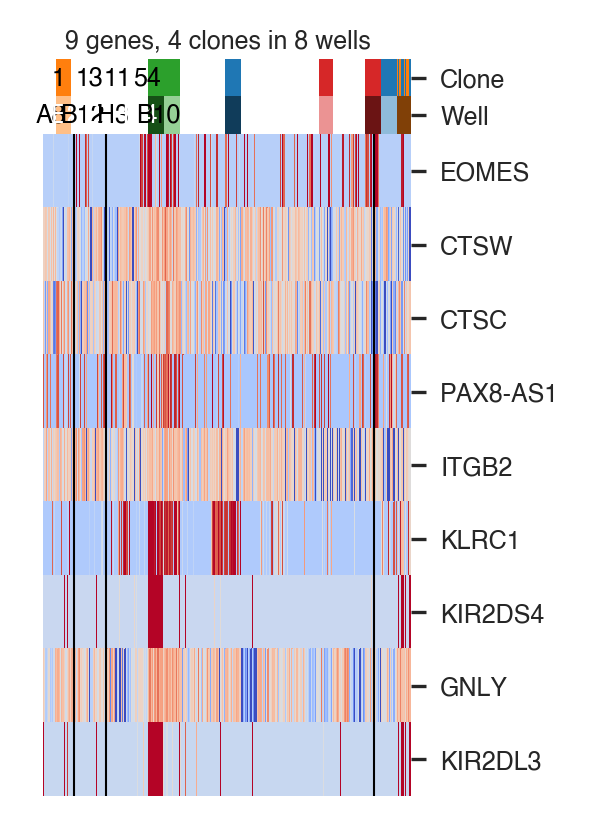

In [109]:
miniheat(X, y_clonewell, markers_13, filename='Panels/Heatmap_13_clone.pdf', genelabel=True)

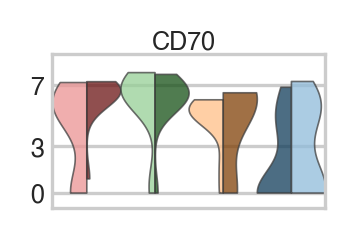

In [60]:
gene = 'CD70'
minivio_split(gene,filename='Panels/ClonalGenes/{}_check.pdf'.format(gene), style='binary')

In [45]:
y_sis_cw

obs_names
P3128_1209    11_H3
P3128_1210    11_H3
P3128_1211    11_H3
P3128_1212    11_H3
P3128_1213    11_H3
              ...  
P3128_1569    54_H4
P3128_1570    11_H4
P3128_1571    11_H4
P3128_1572    11_H4
P3128_1574    54_H4
Name: CloneWell, Length: 108, dtype: object

# Miniature violins

In [54]:
def log2p(x):
    ''' log_2(x+1) function '''
    return np.log1p(x) / np.log(2) 

def exp1m(A):
    ''' An inverse of the np.log2p function. '''
    return np.exp(A*np.log(2)) - 1 

In [55]:
def minivio(gene, gf=X_sis, mf = y_sis_cw, clip = False, style='binary', filename=None):
       
    df = pd.DataFrame(gf[gene].copy())
    
    md = pd.DataFrame(index=mf.index)
    md['CloneWell'] = mf
    df = sort_by(df, md['CloneWell'], cellwells)
    md = sort_by(md, md['CloneWell'], cellwells)
    
    df['Clone'] = [cw.split('_')[0] for cw in md['CloneWell']]
    df['Well'] = [cw.split('_')[1] for cw in md['CloneWell']]
    
    pal = sns.color_palette(n_colors=len(clones_sis))
    pal = pal[-1::-1]
    lut = dict(zip(clones_sis, pal))
    
    wells = df['Well'].unique()
    #well_pal = sns.color_palette("Paired")
    well_pal = wellmap.colors
    #well_pal = sns.cubehelix_palette(len(wells),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    well_lut = dict(zip(wells, well_pal))
    #df[prop] = mf[prop]
    print(well_lut)
    #create a figure
    sns.set_style('darkgrid')
    fig,ax = plt.subplots(figsize=(1.2,0.8), dpi=300)
    setfontsize()
    ax.tick_params(axis='both', which='major', pad=-2)
    # ax.legend_.remove()
    
    if style == 'tune':
        genemean = df[gene].mean()
        genestd = df[gene].std()
        plt.axhline(y=genemean, color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        plt.axhline(y=genemean+genestd, color='gray', linestyle=':', linewidth=0.25)
        plt.axhline(y=genemean-genestd, color='gray', linestyle=':', linewidth=0.25)
        # Create the violin
        sns.violinplot(x='Clone', y=gene, inner=None, width=1.2, scale='width', order=clones_sis, data=df, 
                       saturation=0.8, linewidth=0.4, cut=0, palette=lut)
        sns.swarmplot(x='Clone', y=gene, hue='Well', order=clones_sis, size=2,
                       data=df, palette=well_lut)
        #sns.violinplot(x='Clone', y=gene, hue='Well', inner=None, dodge=False, order=clones_sis, 
        #               data=df, width=0.3, saturation=0.8, linewidth=0.4, cut=0, palette=well_lut)
        ax.set_ylim((max(df[gene].quantile(0.03) - 0.5,0), df[gene].quantile(1.0) + 0.25))
        ax.legend_.remove()
        
    elif style == 'binary':
        
        maxes = df.groupby('Clone').max()[gene]
        nonzeros = df.groupby('Clone').apply(lambda x : (x > log2p(10)).sum() / len(x))[gene]
        for x,clone in enumerate(clones_sis):
            ax.text(x, maxes[clone]+0.2, '.{:0>2}'.format(int(nonzeros[clone]*100)), ha='center')
        #plt.axhline(y=log2p(10), color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        sns.violinplot(x='Clone', y=gene, inner='point', scale='width', order=clones_sis, data=df, saturation=0.8, 
                       linewidth=0.4, cut=0)
        ax.set_ylim((-0.1, df[gene].max()*1.15))
     
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', pad=-1)
    
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    title_lines = ['{}'.format(gene)]
    fig.suptitle('\n '.join(title_lines),y=1.1)
    if filename:
        set_size(fig, (1.2, 0.8))
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [56]:
well_alt = [0,1,0,1,0,1,2,0,1]
clonewells_alt = [clonewells[j]+'_'+str(well_alt[j]) for j in range(len(clonewells))]
cw_alt = {clonewells[j] : clonewells_alt[j] for j in range(len(clonewells))}
cw_alt

{'1_A8': '1_A8_0',
 '1_E2': '1_E2_1',
 '13_B12': '13_B12_0',
 '13_E7': '13_E7_1',
 '11_H3': '11_H3_0',
 '11_H4': '11_H4_1',
 '54_H4': '54_H4_2',
 '54_B4': '54_B4_0',
 '54_B10': '54_B10_1'}

In [57]:
for cw in cw_lut.keys():
    r,g,b = cw_lut[cw]
    print(cw, int(r*255), int(g*255), int(b*255))

1_A8 234 147 147
1_E2 107 19 20
13_B12 149 207 149
13_E7 22 80 22
11_H3 255 191 134
11_H4 127 63 7
54_H4 143 123 97
54_B4 15 59 90
54_B10 143 187 217


In [58]:
def minivio_split(gene, gf=X_sis, mf = y_sis_cw, clip = False, style='binary', show_clones=False, 
                  filename=None):

        
    df = pd.DataFrame(gf[gene].copy())
    
    md = pd.DataFrame(index=mf.index)
    md['CloneWell'] = mf
    df = sort_by(df, md['CloneWell'], clonewells)
    md = sort_by(md, md['CloneWell'], clonewells)
    
    df['Clone'] = [cw.split('_')[0] for cw in md['CloneWell']]
    df['Well'] = [cw.split('_')[1] for cw in md['CloneWell']]
    df['WellBool'] = [cw_alt[cw].split('_')[2] for cw in md['CloneWell']]
    df = df[df['WellBool'] != '2']
    
    #pal = sns.color_palette(n_colors=len(clones_sis))
    #pal = pal[-1::-1]
    #lut = dict(zip(clones_sis, pal))
    
    wells = df['Well'].unique()
    #well_pal = sns.color_palette("Paired")
    #well_pal = wellmap.colors
    #well_pal = sns.cubehelix_palette(len(wells),light=.9, dark=.1, reverse=True, start=1, rot=-2)
    #well_lut = dict(zip(wells, well_pal))
    #print(well_lut)
    #df[prop] = mf[prop]

    #create a figure
    sns.set_style('whitegrid')
    if show_clones:
        figsize=(35*mm, 30*mm)
    else:
        figsize=(30*mm,20*mm)
    fig,ax = plt.subplots(figsize=figsize, dpi=300)
    setfontsize()
    ax.tick_params(axis='both', which='major', pad=-2)
    # ax.legend_.remove()
    maxes = df.groupby('Clone').max()[gene]
    means = df.groupby('Clone').mean()[gene]
    if style == 'tune':
        genemean = df[gene].mean()
        genestd = df[gene].std()
        #plt.axhline(y=genemean, color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        #plt.axhline(y=genemean+genestd, color='gray', linestyle=':', linewidth=0.25)
        #plt.axhline(y=genemean-genestd, color='gray', linestyle=':', linewidth=0.25)
        # Create the violin
        
        
            #ax.text(x, maxes[clone]+0.1, welldict[clone], ha='center')
        
        sns.violinplot(x='Clone', y=gene, width=1.0, scale='width', hue='WellBool', inner=None,
                       order=clones_sis, data=df, saturation=0.8, linewidth=0.4, cut=0, split=True)
        
        violins = ax.collections
        v_no = 0
        for well in wells:
            df_well = df[df['Well'] == well]
            if df_well[gene].max() > 0:
                violin = violins[v_no]
                violin.set_alpha(0.75)
                violin.set_facecolor(well_lut[well])
                v_no += 1
        
        #for j,violin in enumerate(ax.collections):
        #    print(violin.get_array())
        #    violin.set_alpha(0.75)
        #    violin.set_facecolor(well_lut[wells[j]])
        #sns.boxplot(x='Clone', y=gene, hue='Well', fliersize=1, dodge=False, width=0.8,
        #               order=clones_sis, data=df, saturation=0.8, linewidth=0.4)
        
        #sns.swarmplot(x='Clone', y=gene, hue='Well', order=clones_sis, size=2,
        #               data=df, palette=well_lut)
        #sns.violinplot(x='Clone', y=gene, hue='Well', inner=None, dodge=False, order=clones_sis, 
        #               data=df, width=0.3, saturation=0.8, linewidth=0.4, cut=0, palette=well_lut)
        top_put = df[gene].quantile(1.0) + 0.15
        bottom_put = max(df[gene].quantile(0.03) - 0.75,0)
        
        ##for x,clone in enumerate(clones_sis):
        #    ax.text(x, bottom_put, welldict[clone].replace('/',':'), ha='center')
        #ax.text(-0.5,bottom_put, 'Well--', ha='right')
        
        ax.set_yticks([0,int(bottom_put + 2), int(0.5*(bottom_put + top_put)), int(top_put)])
        ax.set_ylim((bottom_put, top_put))
        ax.legend_.remove()
        
    elif style == 'binary':
        nonzeros = df.groupby('Clone')[gene].apply(lambda x : (x > log2p(10)).sum() / len(x))
        
        
        #ax.text(x, maxes[clone]+0.1, welldict[clone].replace('/','|'), ha='center')
        #plt.axhline(y=log2p(10), color='k', linestyle='-', alpha=0.5, linewidth=0.25)
        sns.violinplot(x='Clone', y=gene, width=1.0, scale='width', hue='WellBool', inner=None,
                       order=clones_sis, data=df, saturation=0.8, linewidth=0.4, cut=0, split=True)
        violins = ax.collections
        v_no = 0
        for well in wells:
            df_well = df[df['Well'] == well]
            if df_well[gene].max() > 0:
                violin = violins[v_no]
                violin.set_alpha(0.75)
                violin.set_facecolor(well_lut[well])
                v_no += 1
        #for j,violin in enumerate(ax.collections):
        #    violin.set_alpha(0.75)
        #    violin.set_facecolor(well_lut[wells[j]])
        #sns.violinplot(x='Clone', y=gene, inner='point', scale='width', order=clones_sis, data=df, saturation=0.8, 
        #               linewidth=0.4, cut=0)
        #sns.boxplot(x='Clone', y=gene, hue='Well', fliersize=1, dodge=False, width=0.8,
        #               order=clones_sis, data=df, saturation=0.8, linewidth=0.4)
        
        top_put = df[gene].max() * 1.15
        bottom_put = -1
        ax.set_ylim((bottom_put, df[gene].max()*1.15))
        gmax = df[gene].max()
        ax.set_yticks([0,int(gmax/2), int(gmax)])
        ax.legend_.remove()
        
    if show_clones:
        yrange = top_put - bottom_put
        for x,clone in enumerate(clones_sis):
            ax.text(x, bottom_put- (yrange*0.125), welldict[clone].replace('/',':'), ha='center')
        #ax.text(-0.5,bottom_put- (yrange*0.125), 'Well-', ha='right')
    
        #ax.text(-0.5,bottom_put - (yrange*0.25), 'Clone-', ha='right')
        ax.tick_params(axis='x', which='major', pad=5)
        
    else:
        ax.set_xticks([])
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='y', which='major', pad=-1.5)
    
    
    #ax.text(-0.3,bottom_put, 'Clone: ', ha='right', va='bottom', fontsize=5)
    #ax.set_yticks()
    
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    title_lines = ['{}'.format(gene)]
    fig.suptitle('\n '.join(title_lines),y=1.0)
    if filename:
        set_size(fig, figsize)
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

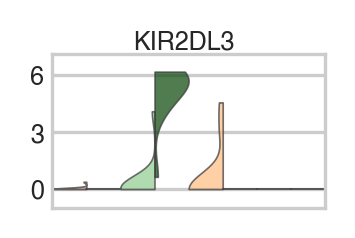

In [92]:
gene = 'KIR2DL3'
minivio_split(gene,filename='Panels/ClonalGenes/{}.pdf'.format(gene), style='binary')

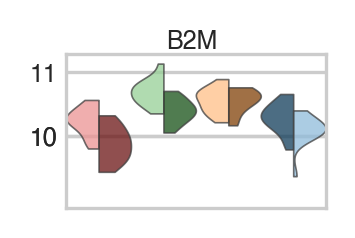

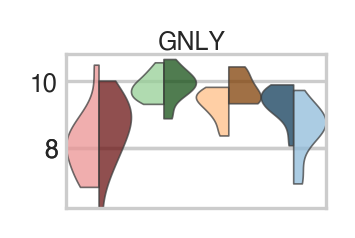

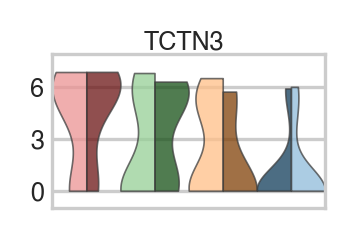

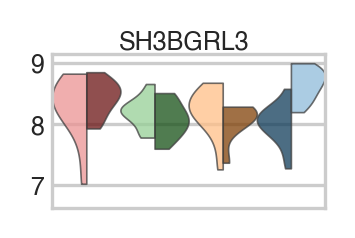

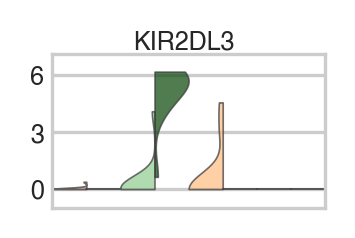

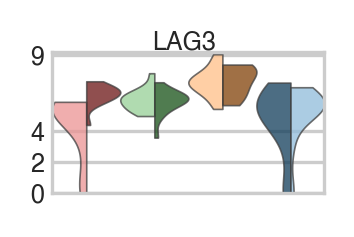

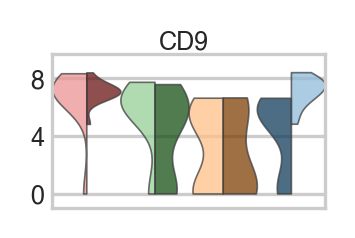

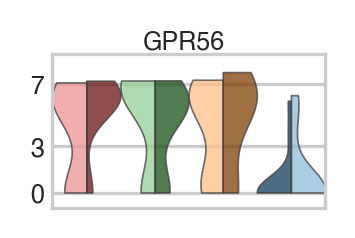

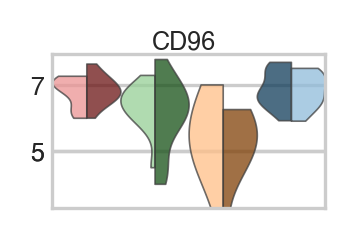

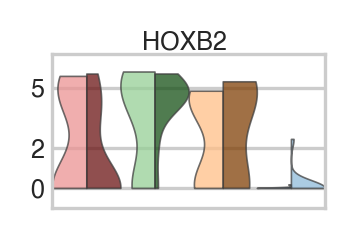

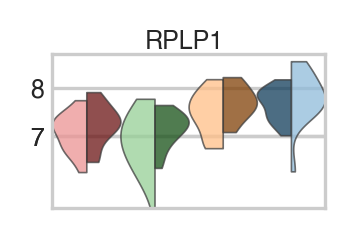

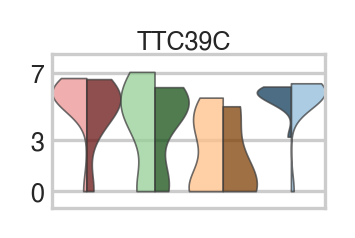

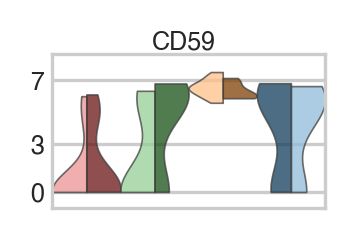

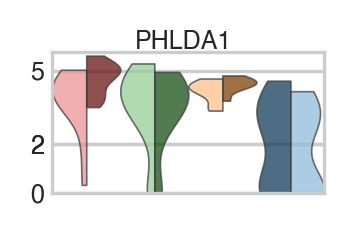

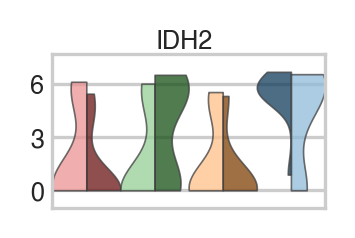

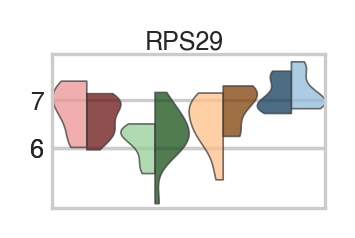

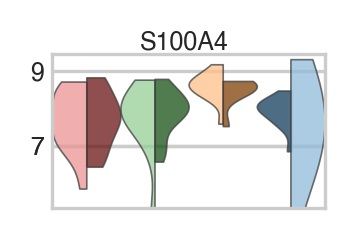

In [93]:
for gene in ['B2M', 'GNLY','TCTN3','SH3BGRL3','KIR2DL3','LAG3', 'CD9', 'GPR56', 
             'CD96', 'HOXB2', 'RPLP1', 'TTC39C', 'CD59', 'PHLDA1', 'IDH2', 'RPS29', 'S100A4']:
    if X[gene].quantile(0.2) == 0:
        style = 'binary'
    else:
        style = 'tune'
    minivio_split(gene,filename='Panels/ClonalGenes/{}.pdf'.format(gene), style=style)

# Clonal and well-to-well variability.

In [94]:
clone_df = adata['sc'].obs[['Clone_ID', 'Well_ID']]
clone_df.head()

nested_cells = [cell for cell in clone_df.index if not 
                ( (clone_df.loc[cell, 'Well_ID'] == 'H4') and 
                 (clone_df.loc[cell, 'Clone_ID'] == '54'))]
nested_cells = [cell for cell in nested_cells if clone_df.loc[cell, 'Clone_ID'] in 
                ['1','11','13','54']]
print('{} Cells nested out of {} total cells'.format(len(nested_cells), len(clone_df)))

X_nested = X.loc[nested_cells]
y_nested_clone = y_clone[nested_cells]
y_nested_well = y_well[nested_cells]
y_nested_cw = y_nested_clone + '_' + y_nested_well

103 Cells nested out of 324 total cells


In [95]:
clone_df.head()

,Clone_ID,Well_ID
obs_names,,
P3128_1193,3,D2
P3128_1194,3,D2
P3128_1195,3,D2
P3128_1197,3,D2
P3128_1198,3,D2


In [96]:
clone_df.loc[nested_cells].Well_ID.unique()

array(['H3', 'E7', 'B12', 'B4', 'A8', 'E2', 'B10', 'H4'], dtype=object)

In [97]:
cw_df = (clone_df['Clone_ID'].astype(str) + '_' + clone_df['Well_ID'].astype(str)).loc[nested_cells]
cw_df.head()

obs_names
P3128_1209    11_H3
P3128_1210    11_H3
P3128_1211    11_H3
P3128_1212    11_H3
P3128_1213    11_H3
dtype: object

In [98]:
def DoubleANOVA(gf, mf, prop1 = 'Clone_ID', prop2 = 'Well_ID'):
    '''
    Warning:  Does not check for nesting!  Be careful.
    '''
    if len(gf) != len(mf):
        print('Error:  different populations in data and metadata.')
        return None
    
    a = len(mf[prop1].unique())
    b = len(mf[prop2].unique()) / a
    n = mf[prop2].value_counts().min()
    
    A_df = pd.DataFrame(index=gf.columns, columns=['F_gp', 'p_gp'])
    
    md = mf.copy()
    FC_group = f_classif(gf, md[prop1])
    A_df['F_gp'] = FC_group[0]
    A_df['p_gp'] = FC_group[1]
    
    for clone in md[prop1].unique():
        gf_well = gf[md[prop1] == clone]
        FC_well = f_classif(gf_well, md[prop2].loc[gf_well.index])
        A_df['F_well_'+clone] = FC_well[0]
        A_df['p_well_'+clone] = FC_well[1]
    clone_cols = ['p_well_'+clone for clone in md[prop1].unique()]
    A_df['p_well'] = len(clone_cols) * A_df[clone_cols].min(axis=1)
    A_df['p_well'] = A_df['p_well'].clip(0,1)
    return A_df

In [99]:
test_cells = cw_df.index
DA = DoubleANOVA(X.loc[test_cells], clone_df.loc[test_cells]).sort_values('p_gp')

In [100]:
DA.sort_values('p_well').index

Index(['KIR2DL3', 'KIR2DS4', 'HLA-DRB5', 'SH3BGRL3', 'TIMD4', 'HLA-DRB1',
       'HLA-DPA1', 'CCNC', 'CAAP1', 'HLA-DRB6',
       ...
       'KIAA0247', 'IL12RB2', 'ALCAM', 'YBX1', 'NUP188', 'CENPBD1P1', 'SNX14',
       'ENTPD6', 'VRK2', 'B3GNTL1'],
      dtype='object', name='gene_name', length=8663)

<AxesSubplot:xlabel='p_well'>

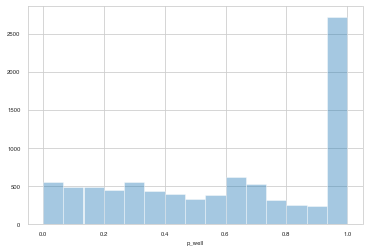

In [101]:
sns.distplot(DA['p_well'], kde=False)

In [102]:
2.5 / mm

63.5

,p_gp,p_well,Clonal significance -log(p),Well sig. within clones -log(p)
gene_name,,,,
SELL,1.188041e-20,1.967756e-01,19.925169,0.706029
CAPG,2.095561e-16,2.025761e-03,15.678699,2.693412
FOXP3-1,5.727653e-16,8.630882e-01,15.242023,0.063945
KLRB1,5.991446e-16,6.677181e-01,15.222468,0.175407
CD40LG,1.045180e-13,6.343267e-01,12.980809,0.197687
HPGD,1.563325e-13,1.000000e+00,12.805951,-0.000000
KLRC1,1.633513e-13,1.908676e-02,12.786878,1.719268
CD28,2.535325e-12,6.972011e-01,11.595966,0.156642
B2M,2.845131e-12,2.843075e-03,11.545897,2.546212


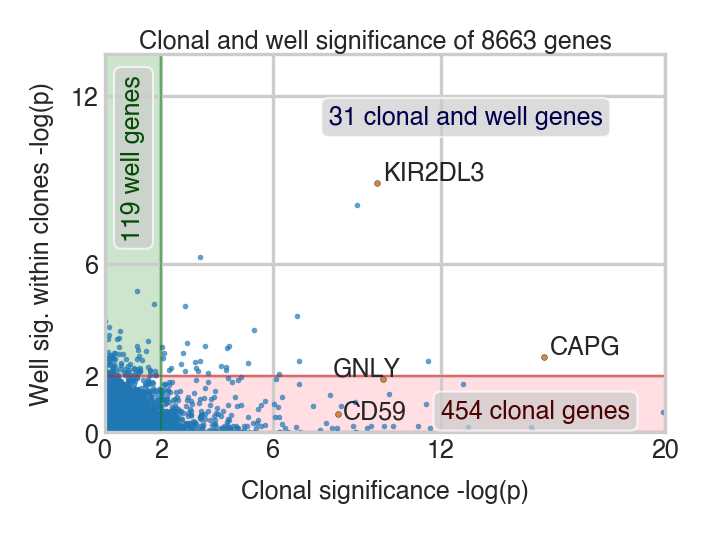

In [103]:
sns.set_style('whitegrid')
figsize=(60*mm,45*mm)
fig,ax = plt.subplots(figsize=figsize, dpi=300)
setfontsize()
ax.tick_params(axis='both', which='major', pad=-2)

plot_df = DA[['p_gp','p_well']] 
plot_df['Clonal significance -log(p)'] = -np.log10(plot_df['p_gp'])
plot_df['Well sig. within clones -log(p)'] = -np.log10(plot_df['p_well'])
sns.scatterplot(x='Clonal significance -log(p)', y='Well sig. within clones -log(p)', 
                data=plot_df, edgecolor=None, s=1.5, alpha=0.7)
plt.ylim(0,13.5)
plt.xlim(0,20)

x_series = plot_df['Clonal significance -log(p)']
y_series = plot_df['Well sig. within clones -log(p)']
display(plot_df[(plot_df['Clonal significance -log(p)'] > 9) | (plot_df['Well sig. within clones -log(p)'] > 3.5) ])
#genes_plot = plot_df[(6.1 > plot_df['Clone -log(p)']) & (plot_df['Clone -log(p)'] > 6) & (plot_df['Well -log(p)'] < 0.1) ].index
def label_point(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        if i == 'GNLY':
            offset = -2
        else:
            offset = 0
        ax.text(point['x']+0.2+offset, point['y']+np.random.choice([0.1,-0.2]), i)

#genes_plot = ['GNLY','KIR2DL3','CD59','B2M','KLRC1','SELL']
genes_plot = ['KIR2DL3','CD59','GNLY','CAPG']
label_point(x_series[genes_plot], y_series[genes_plot], plt.gca())
sns.scatterplot(x='Clonal significance -log(p)', y='Well sig. within clones -log(p)', 
                data=plot_df.loc[genes_plot], edgecolor='k', s=2.0, alpha=0.7)

ax.axhline(2, color='red', linewidth=0.5, alpha=0.5)
ax.axvline(2, color='green', linewidth=0.5, alpha=0.5)

ax.add_patch(plt.Rectangle((2,0), 20, 2, zorder=-2, color='pink', alpha=0.5))
ax.add_patch(plt.Rectangle((0,2), 2, 16, zorder=-2, color='green', alpha=0.2))

cgeneno = (plot_df['Clonal significance -log(p)'] > 2).sum()
wgeneno = (plot_df['Well sig. within clones -log(p)'] > 2).sum()
cwgeneno = ((plot_df['Well sig. within clones -log(p)'] > 2) & (plot_df['Clonal significance -log(p)'] > 2)).sum()

bbox={'fc': '0.8', 'alpha': 0.7, 'boxstyle':'round', 'linewidth':0.5}

ax.text(12,0.5,'{} clonal genes'.format(cgeneno), color=(0.3,0,0), 
        bbox=bbox )
ax.text(0.6,7,'{} well genes'.format(wgeneno), rotation=90, color=(0,0.3,0), bbox=bbox)
ax.text(8,11,'{} clonal and well genes'.format(cwgeneno), color=(0,0,0.3), bbox=bbox)

ax.set_xticks([0,2,6,12,20])
ax.set_yticks([0,2,6,12])
plt.suptitle('Clonal and well significance of {} genes'.format(len(x_series)), y=0.93)

set_size(fig, figsize)
plt.savefig('Panels/Clonewell_sig.pdf', bbox_inches='tight')
    
plt.show()
